# A Rigorous Machine Learning Pipeline (Supervised Binary Classification):
* Author: Ryan Urbanowicz, PhD with contributions from Robert Zhang (WH '22, SEAS '22)
*  Affiliation: University of Pennsylvania - Department of Biostatistics, Epidemiology, and Informatics & Institute for Biomedical Informatics (IBI) 
* Date: 9/1/20
***
## Introduction
This notebook presents an example of a 'rigorous' machine learning (ML) analysis pipeline that could be reasonablly applied to various supervised learning classification tasks. This pipeline was developed with biomedical data mining/modeling in mind. While this pipeline offers a comprehensive and rigorous proposed analysis, we do not suggest that this is necessarily the 'best' or 'only' way to conduct an appropriate binary classification ML analysis. This notebook simplifies and expands upon a pipeline previously made available on our GitHub page: https://github.com/UrbsLab/ExSTraCS_ML_Pipeline_Binary_Notebook
***
## Environment Requirements
In order to run this pipeline as a Jupyter Notebook you must have the proper environment set up on your computer. Python 3 as well as a number of Python packages are required.  Most of these requirements are satisfied by installing the most recent version of anaconda (https://docs.anaconda.com/anaconda/install/). We used Anaconda3 with python version 3.7.7 during this pipeline development. In addition to the packages included in anaconda, the following packages will need to be installed separately (or possibly updated, if you have an older version installed):

* scikit-rebate (To install: pip install skrebate)
* xgboost (To install: pip install xgboost)
* lightgbm (To install: pip install lightgbm)
* optuna (To install: pip install optuna)
* eLCS (To install: pip install scikit-elcs)
* XCS (To install: pip install scikit-XCS)
* ExSTraCS (To install: pip install scikit-ExSTraCS)

Additionally, while currently commented out in the file (modeling_methods.py) if you want the optuna hypterparameter sweep figures to appear within the jupyter notebook (via the command 'fig.show()' ) you will need to run the following installation commands.  This should only be required if you edit the python file to uncomment this line for any or all of the ML modeling algorithms. 

* pip install -U plotly>=4.0.0
* conda install -c plotly plotly-orca

***
## Dataset Requirements
This notebook loads a single dataset to be run through the entire pipeline. Here we summarize the requirements for this dataset:
* Ensure your data is in a single file: (If you have a pre-partitioned training/testing dataset, you should combine them into a single dataset before running this notebook)
* Any dataset specific cleaning, feature transformation, or feature engineering that may be needed in order to maximize ML performance should be conducted by the user separately or added to the beginning of this notebook. 
* The dataset should be in tab-delimited .txt format to run this notebook (as is).  Commented-out code to load a comma separated file (.csv) and excel file (.xlsx) is included in the notebook as an alternative. 
* Missing data values should be empty or indicated with an 'NA'.
* Dataset includes a header with column names. This should include a column for the binary class label and (optionally) a column for the instance ID, as well as columns for other 'features', e.g. independend variables. 
* The class labels should be 0 for the major class (i.e. the most frequent class), and 1 for the minor class.  This is important for generation of the precision/recall curve (PRC) plots. 
* This dataset is saved in the working directory containing the jupyter notebook file, and all other files in this repository.
* All variables in the dataset have been numerically encoded (otherwise additional data preprocessing may be needed)
***
## Notebook Organization
#### Part 1: Exploratory analysis, data cleaning, and creating n-fold CV partitioned datasets 
- Instances missing a class value are excluded
- The user can indicate other columns that should be excluded from the analysis
- The user can turn on/off the option to apply standard scaling to the data prior to CV partitioning or imputation
    - We use no scaling by default. This is because most methods should work properly without it, and in applying the model downstream, it is difficult to properly scale new data so that models may be re-applied later.
    - ANN modeling is sensitive to feature scaling, thus without it, performance not be as good. However this is only one of many challenges in getting ANN to perform well. 
- The user can turn on/off the option to impute missing values following CV partitioning
- The user can turn on/off the option for the code to automatically attempt to discriminate nominal from ordinal features
- The user can choose the number of CV partitions as well as the strategy for CV partitioning (i.e.  random (R), stratified (S), and matched (M) 
- CV training and testing datasets are saved as .txt files so that the same partitions may be analyzed external to this code
    
#### Part 2: Feature selection
- The user can turn on/off the option to filter out the lowest scoring features in the data (i.e. to conduct not just feature importance evaluation but feature selection)
- Feature importance evaluation and feature selection are conducted within each respective CV training partition
- The pipeline reports feature importance estimates via two feature selection algorithms:
    - Mutual Information: Proficient at detecting univariate associations
    - MultiSURF: Proficient at detecting univariate associations, 2-way epistatic interactions, and heterogeneous associations
    
- When selected by the user, feature selection conservatively keeps any feature identified as 'potentially relevant' (i.e. score > 0) by either algorithm
- Since MultiSURF scales quadratically with the number of training instances, there is an option to utilize a random subset of instances when running this algorithm to save computational time
    
#### Part 3: Machine learning modeling
- Seven ML modeling algorithms have been implemented in this pipeline:
    - Logistic Regression (scikit learn)
    - Decision Tree (scikit learn)
    - Random Forest (scikit learn)
    - Naïve Bayes (scikit learn)
    - XGBoost (separate python package)
    - LightGBM (separate python package)
    - SVM (scikit learn)
    - ANN (scikit learn)
    - k-Neighbors Classifier (scikit learn)
    - Gradient Boosting Classifier (scikit learn)
    - eLCS - a basic Learning Classifier System (LCS) algorithm (scikit learn compatible)
    - XCS - our own Python implementation of this 'best-studied' LCS algorithm (scikit learn compatible)
    - ExSTraCS (v2.0.2.1) - our own LCS algorithm designed to tackle the unique challenges of biomedical data (scikit learn compatible)
- User can select any subset of these methods to run
- ML modeling is conducted within each respective CV training partition on the respective feature subset selected within the given CV partition
- ML modeling begins with a hyperparameter sweep conducted with a grid search of hard coded run parameter options (user can edit as needed)
- Balanced accuracy is applied as the evaluation metric for the hyperparameter sweep

#### Part 4: ML feature importance vizualization

***
## Schematic of ML Analysis Pipeline

<img src="ML pipeline schematic3.png" />

---
# Import Necessary Python Packages 

In [1]:
import pandas as pd
import numpy as np
import os
import random
import copy
import sys
import pickle
import time

from data_processing_methods import cv_partitioner
from data_processing_methods import identifyCategoricalFeatures
from data_processing_methods import imputeCVData
from data_processing_methods import dataScaling

from feature_selection_methods import reportAllFS
from feature_selection_methods import reportTopFS
from feature_selection_methods import sort_save_fi_scores
from feature_selection_methods import sort_save_fs_fi_scores
from feature_selection_methods import run_mi
from feature_selection_methods import run_multisurf
from feature_selection_methods import selectFeatures
from feature_selection_methods import genFilteredDatasets

from modeling_methods import classEval
from modeling_methods import roc_plot_single
from modeling_methods import save_performance
from modeling_methods import save_FI
from modeling_methods import eval_Algorithm_FI

#Statistics packages
from scipy import stats

#Visualization Packages:
#This code ensures that the output of plotting commands is displayed inline directly below the code cell that produced it.
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) # display all the columns
import scipy.stats as scs
from scipy.stats import randint
from matplotlib import rc
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import Progress bar:
from tqdm import tnrange, tqdm_notebook

---
# Set Dataset Pipeline Variables (Mandatory)
These variables values will have to be respecified to run this pipeline on a given dataset or computer

In [2]:
#Unique dataset name (include dataset extension) (must be updated for a given dataset analysis)
#target_data = 'hcc-data_example.txt' 
target_data = 'hcc-data_example.txt' 

#Dataset specific constants (Must be updated for a given dataset)
outcomeLabel = 'Class Attribute' #i.e. class outcome column label
categoricalOutcome = True  #Is outcome nominal (i.e. discrete/classification) This script will not function correctly if False!
instLabel = None #If data includes instance labels, given respective column name here, otherwise put None
ignore_columns = [] #list of column names to exclude from the analysis (only insert column names if needed, otherwise leave empty)
categorical_variables = [] #Leave empty for 'auto-detect' otherwise list feature names to be treated as categorical.

---
# Set Other Pipeline Variables (Optional) 
These variables can be left as is, or modified to update key aspects of how the ML pipeline will be run and what methods will be included

In [3]:
#Descriptive Analysis options ------------------------------------------------------------------------------------
doCorrelation = True #Generate visualization of feature correlations (Not recommended for feature sets > 100)
doUA = True #Perform a univariate analysis of features in the dataset 

#Cross Validation run parameters (change as needed) --------------------------------------------------------------
cv_partitions = 10 #number of CV partitions (3-10 recommended)
partition_method = 'S' #Options: random (R), stratified (S), matched (M)
matchName = None #Name of column used for matched CV partitioning. Put None otherwise.

#Data cleaning options--------------------------------------------------------------------------------------------
scaleData = True  #Prescale original dataset values (important for ML and feature importance interpretation of some algorithms)
imputeData = True  #Impute missing values (separate methods used for categorical vs ordinal variables)
autoDetectCategorical = True #keep in mind that this can incorectly identify some ordinal values as being categorical (e.g. tumor state/grade)
categoricalCutoff = 10 #If the number of unique values is greater than this value, the feature is assumed to be ordinal/continuous-valued

#Feature Selection----------------------------------------------------------------------------------------------
algorithms = ['mutual_information','multisurf']
instanceSubset = 2000 #Sample subset size to use with MultiSURF (since they scale quandratically with n)
maxFeaturesToKeep = 50 #Maximum number of features to keep during feature selection - pute None if no max desired)
filterPoorFeatures = True
topResults = 20 #Top features to illustrate in feature selection results figures

#ML Modeling -----------------------------------------------------------------------------------------------------
#Algorithms available: logistic_regression,decision_tree, random_forest, naive_bayes, xg_boost, lg_boost, SVM, ANN
algorithmsToRun = ['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'XGB', 'LGB','SVM','ANN','ExSTraCS','ExSTraCS_QRF','eLCS','XCS','gradient_boosting','k_neighbors'] 
methodsKey = ('Logistic Regression', 'Decision Tree', 'Random Forest', 'Naïve Bayes','XGB','LGB', 'SVM', 'ANN','ExSTraCS 2.0','ExSTraCS 2.0 QRF','eLCS','XCS','GB','KN')
algColors = ['black','yellow','orange','grey','purple', 'aqua', 'red', 'blue','lightcoral','firebrick','deepskyblue','slategrey','bisque','seagreen']

#algorithmsToRun = ['gradient_boosting','k_neighbors'] 
#methodsKey = ('GB','KN')
#algColors = ['bisque','seagreen']

#Notebook run parameters (i.e. set random seed for notebook replication consistency)
randomSeed = 42
random.seed(randomSeed)

## ML Modeling Hyperparamters

In [4]:
#Optima Hyperparameter sweep run parameters
n_trials = 100 #number of bayesian hyperparameter optimization trials (using optuna)
scoring_metric = 'balanced_accuracy' #metric used to pick best hyperparamters
hype_cv = 3 #Internal cv partitions for hyperparamter sweep evaluations
timeout = 300 #Seconds until hyperparameter sweep stopped - 3600 sec = 1 hour, 300 sec = 5 min
lcs_timeout = 300

#Logistic Regression
param_grid_LR = {'penalty' : ['l2','l1'],
                'C' : [1e-5, 1e5], 
                'dual' : [True, False],
                'solver' : ['newton-cg','lbfgs', 'liblinear', 'sag','saga'],
                'class_weight' : [None, 'balanced'],
                'max_iter' : [10, 1000],
                'n_jobs' : [-1]}

#Decision Tree
param_grid_DT = {'criterion' : ['gini', 'entropy'],
                'splitter' : ['best', 'random'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'class_weight' : [None, 'balanced']}

#Random Forest
param_grid_RF = {'n_estimators': [10,1000],
                'criterion' : ['gini', 'entropy'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'bootstrap' : [True],
                'oob_score' : [False, True],
                'n_jobs' : [-1],
                'class_weight' : [None, 'balanced']}

#XG Boost - note: class weight balance is included as option internally
param_grid_XGB = {'booster': ['gbtree'],
                'objective' : ['binary:logistic'],
                'verbosity' : [0],
                'reg_lambda' : [1e-8, 1.0],
                'alpha' : [1e-8, 1.0],
                'eta' : [1e-8, 1.0],
                'gamma' : [1e-8, 1.0],
                'max_depth' : [1, 30],
                'grow_policy' : ['depthwise', 'lossguide'],
                'n_estimators': [10,1000],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'subsample' : [0.5, 1.0],
                'min_child_weight': [0.1, 10],
                'colsample_bytree': [0.1, 1.0]}

#LG Boost - note: class weight balance is included as option internally
param_grid_LGB = {'objective' : ['binary'],
                'metric': ['binary_logloss'],
                'verbosity' : [-1],
                'boosting_type': ['gbdt'],
                'num_leaves': [2,256],
                'max_depth' : [1, 30],
                'lambda_l1': [1e-8, 10.0],
                'lambda_l2': [1e-8, 10.0],
                'feature_fraction': [0.4, 1.0],
                'bagging_fraction': [0.4, 1.0],
                'bagging_freq': [1,7],
                'min_child_samples': [5,100],
                'n_estimators': [10,1000]}

#SVM
param_grid_SVM = {'kernel' : ['linear','poly','rbf'],
                'C': [0.1, 1000],
                'gamma': ['scale'],
                'degree': [1,6],
                'probability' : [True],
                'class_weight' : [None, 'balanced']}
        
#ANN
param_grid_ANN = {'n_layers' : [1,3],
                'layer_size' : [1,100],
                'activation': ['identity','logistic', 'tanh', 'relu'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'momentum': [.1,.9],
                'solver': ['sgd', 'adam'],
                'batch_size': ['auto'],
                'alpha': [0.0001, 0.05],
                'max_iter' : [200]}

#ExSTraCS
# param_grid_ExSTraCS = {'learning_iterations':[20000,50000,100000,200000],
#                       'N':[500,1000,2000],
#                       'nu':[1,5,10]}

# param_grid_ExSTraCS = {'learning_iterations':[1000,5000],
#                       'N':[500,1000],
#                       'nu':[1,5]}

param_grid_ExSTraCS = {'learning_iterations':[200000],
                      'N':[2000],
                      'nu':[1]}

#eLCS
# param_grid_eLCS = {'learning_iterations':[20000,50000,100000,200000],
#                       'N':[500,1000,2000],
#                       'nu':[1,5,10]}

param_grid_eLCS = {'learning_iterations':[200000],
                      'N':[2000],
                      'nu':[1]}

#XCS
# param_grid_XCS = {'learning_iterations':[20000,50000,100000,200000],
#                       'N':[500,1000,2000],
#                       'nu':[1,5,10]}

param_grid_XCS = {'learning_iterations':[200000],
                      'N':[2000],
                      'nu':[1]}

param_grid_GB = {'loss':['deviance', 'exponential'],'learning_rate': [1e-2, 1],'min_samples_leaf':[1,200],
                'max_depth':[1,10],'max_leaf_nodes':[None],'tol':[1e-7],'n_iter_no_change':[1,20],
                'validation_fraction':[0.01, 0.31, 0.01]}

param_grid_KN = {'n_neighbors':[1,100],'weights':['uniform', 'distance'],'p':[1,5],'metric':['euclidean', 'minkowski']}

param_grid = {} #stores all user selected algorithm hyperparameters

for algorithm in algorithmsToRun: #['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'xg_boost','SVM','ANN'] 
    if algorithm == 'logistic_regression':
        param_grid['logistic_regression'] = param_grid_LR
    elif algorithm == 'decision_tree':
        param_grid['decision_tree'] = param_grid_DT
    elif algorithm == 'random_forest':
        param_grid['random_forest'] = param_grid_RF
    elif algorithm == 'naive_bayes':
        pass #no hyperparameters
    elif algorithm == 'XGB':
        param_grid['XGB'] = param_grid_XGB
    elif algorithm == 'LGB':
        param_grid['LGB'] = param_grid_LGB
    elif algorithm == 'SVM':
        param_grid['SVM'] = param_grid_SVM
    elif algorithm == 'ANN':
        param_grid['ANN'] = param_grid_ANN
    elif algorithm == 'ExSTraCS':
        param_grid['ExSTraCS'] = param_grid_ExSTraCS
    elif algorithm == 'ExSTraCS_QRF':
        param_grid['ExSTraCS_QRF'] = param_grid_ExSTraCS
    elif algorithm == 'eLCS':
        param_grid['eLCS'] = param_grid_eLCS
    elif algorithm == 'XCS':
        param_grid['XCS'] = param_grid_XCS
    elif algorithm == 'gradient_boosting':
        param_grid['gradient_boosting'] = param_grid_GB
    elif algorithm == 'k_neighbors':
        param_grid['k_neighbors'] = param_grid_KN
    else:
        print("Error: Algorithm not found!")

#Visualization ---------------------------------------------------------------------------------------------------
focus_metric = 'Balanced Accuracy'

#Statistical Significance-----------------------------------------------------------------------------------------
sig_cutoff = 0.05

---
# Notebook/Folder Initialization
For simplicity it is recommended that this not be altered.

In [5]:
#Standard Names (no need to change)
output_folder = 'results'
cv_data_folder = 'cv_datasets'
ua_folder = 'univariate'
model_folder = 'models'

#Working directory path automatically detected
wd_path = os.getcwd()
wd_path = wd_path.replace('\\','/')
wd_path = wd_path+'/'
print("Working Directory: "+wd_path)

#Save data name without extension for later file labeling
data_name = target_data.split('.')[0] 

#Create output folder if it doesn't already exist
if not os.path.exists(wd_path+(output_folder)):
    os.mkdir(wd_path+(output_folder))

#Create CV dataset folder if it doesn't already exist
if not os.path.exists(wd_path+(cv_data_folder)):
    os.mkdir(wd_path+(cv_data_folder))

#Create univariate analysis folder if it doesn't already exist
if not os.path.exists(wd_path+(ua_folder)):
    os.mkdir(wd_path+(ua_folder))
    
#Create model pickle folder if it doesn't already exist
if not os.path.exists(wd_path+(model_folder)):
    os.mkdir(wd_path+(model_folder))

data_changed = False #Keeps track of whether cleaning changed original dataset (leave this set to False)

run_time_dict = {}
notebook_start_time = time.time()

Working Directory: C:/Users/ryanu/Documents/Analysis/skml_binary_pipe/


---
# Load Dataset
This code assumes that the data is being loaded as a tab delimited '.txt' file with columns as features/outcome, and rows as instances. It is also assumed that the target file includes a header and that missing values are indicated with 'NA' or an empty cell. This command can be updated depending on users dataset format. 

In [6]:
#td = pd.read_csv(target_data, na_values='NA', sep = ",") #Data loaded so that blank excell cells are 'NA'
td = pd.read_csv(target_data, na_values='NA', sep = "\t") #Data loaded so that blank excell cells are 'NA'
td.shape

(165, 50)

### Debugging data simplification (This code should be commented out during normal run)

In [7]:
#td = td.sample(frac=0.5, replace=False, random_state=randomSeed)

---
# Initial Exploratory Analysis

In [8]:
# Count the number of rows and columns
num_rows = td.shape[0]
print('Dataset contains '+str(num_rows)+' rows.')
num_cols = td.shape[1]
print('Dataset contains '+str(num_cols)+' columns.')

Dataset contains 165 rows.
Dataset contains 50 columns.


In [9]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Gender                            165 non-null    int64  
 1   Symptoms                          147 non-null    float64
 2   Alcohol                           165 non-null    int64  
 3   Hepatitis B Surface Antigen       148 non-null    float64
 4   Hepatitis B e Antigen             126 non-null    float64
 5   Hepatitis B Core Antibody         141 non-null    float64
 6   Hepatitis C Virus Antibody        156 non-null    float64
 7   Cirrhosis                         165 non-null    int64  
 8   Endemic Countries                 126 non-null    float64
 9   Smoking                           124 non-null    float64
 10  Diabetes                          162 non-null    float64
 11  Obesity                           155 non-null    float64
 12  Hemochro

In [10]:
td.describe()

Gender   Symptoms      Alcohol  Hepatitis B Surface Antigen  \
count  165.000000  147.000000  165.000000                   148.000000   
mean     0.806061    0.639456    0.739394                     0.108108   
std      0.396586    0.481800    0.440302                     0.311571   
min      0.000000    0.000000    0.000000                     0.000000   
25%      1.000000    0.000000    0.000000                     0.000000   
50%      1.000000    1.000000    1.000000                     0.000000   
75%      1.000000    1.000000    1.000000                     0.000000   
max      1.000000    1.000000    1.000000                     1.000000   

       Hepatitis B e Antigen  Hepatitis B Core Antibody  \
count             126.000000                 141.000000   
mean                0.007937                   0.269504   
std                 0.089087                   0.445284   
min                 0.000000                   0.000000   
25%                 0.000000                   0.000000   
50%                 0.000000                   0.000000   
75%                 0.000000                   1.000000   
max                 1.000000                   1.000000   

       Hepatitis C Virus Antibody   Cirrhosis  Endemic Countries     Smoking  \
count                  156.000000  165.000000         126.000000  124.000000   
mean                     0.217949    0.903030           0.079365    0.508065   
std                      0.414182    0.296817           0.271387    0.501963   
min                      0.000000    0.000000           0.000000    0.000000   
25%                      0.000000    1.000000           0.000000    0.000000   
50%                      0.000000    1.000000           0.000000    1.000000   
75%                      0.000000    1.000000           0.000000    1.000000   
max                      1.000000    1.000000           1.000000    1.000000   

         Diabetes     Obesity  Hemochromatosis  Arterial Hypertension  \
count  162.000000  155.000000       142.000000             162.000000   
mean     0.345679    0.129032         0.049296               0.364198   
std      0.477064    0.336322         0.217251               0.482697   
min      0.000000    0.000000         0.000000               0.000000   
25%      0.000000    0.000000         0.000000               0.000000   
50%      0.000000    0.000000         0.000000               0.000000   
75%      1.000000    0.000000         0.000000               1.000000   
max      1.000000    1.000000         1.000000               1.000000   

       Chronic Renal Insufficiency  Human Immunodeficiency Virus  \
count                   163.000000                    151.000000   
mean                      0.122699                      0.019868   
std                       0.329103                      0.140009   
min                       0.000000                      0.000000   
25%                       0.000000                      0.000000   
50%                       0.000000                      0.000000   
75%                       0.000000                      0.000000   
max                       1.000000                      1.000000   

       Nonalcoholic Steatohepatitis  Esophageal Varices  Splenomegaly  \
count                    143.000000          113.000000     150.00000   
mean                       0.055944            0.610619       0.56000   
std                        0.230621            0.489782       0.49805   
min                        0.000000            0.000000       0.00000   
25%                        0.000000            0.000000       0.00000   
50%                        0.000000            1.000000       1.00000   
75%                        0.000000            1.000000       1.00000   
max                        1.000000            1.000000       1.00000   

       Portal Hypertension  Portal Vein Thrombosis  Liver Metastasis  \
count           154.000000              162.000000        161.000000   
mean              

In [11]:
td.dtypes

Gender                                int64
Symptoms                            float64
Alcohol                               int64
Hepatitis B Surface Antigen         float64
Hepatitis B e Antigen               float64
Hepatitis B Core Antibody           float64
Hepatitis C Virus Antibody          float64
Cirrhosis                             int64
Endemic Countries                   float64
Smoking                             float64
Diabetes                            float64
Obesity                             float64
Hemochromatosis                     float64
Arterial Hypertension               float64
Chronic Renal Insufficiency         float64
Human Immunodeficiency Virus        float64
Nonalcoholic Steatohepatitis        float64
Esophageal Varices                  float64
Splenomegaly                        float64
Portal Hypertension                 float64
Portal Vein Thrombosis              float64
Liver Metastasis                    float64
Radiological Hallmark           

In [12]:
td.nunique()

Gender                                2
Symptoms                              2
Alcohol                               2
Hepatitis B Surface Antigen           2
Hepatitis B e Antigen                 2
Hepatitis B Core Antibody             2
Hepatitis C Virus Antibody            2
Cirrhosis                             2
Endemic Countries                     2
Smoking                               2
Diabetes                              2
Obesity                               2
Hemochromatosis                       2
Arterial Hypertension                 2
Chronic Renal Insufficiency           2
Human Immunodeficiency Virus          2
Nonalcoholic Steatohepatitis          2
Esophageal Varices                    2
Splenomegaly                          2
Portal Hypertension                   2
Portal Vein Thrombosis                2
Liver Metastasis                      2
Radiological Hallmark                 2
Age at diagnosis                     51
Grams of Alcohol per day             19


### Assess Missingness in Columns

In [13]:
for i,c in enumerate(td.columns):
    na_percent = np.sum(td[c].isnull())/len(td)*100
    if na_percent > 0:
        print(c,'\t\t% Missing(N/A) = ',np.sum(td[c].isnull())/len(td)*100)

Symptoms  		% Missing(N/A) =  10.909090909090908
Hepatitis B Surface Antigen 		% Missing(N/A) =  10.303030303030303
Hepatitis B e Antigen 		% Missing(N/A) =  23.636363636363637
Hepatitis B Core Antibody 		% Missing(N/A) =  14.545454545454545
Hepatitis C Virus Antibody 		% Missing(N/A) =  5.454545454545454
Endemic Countries 		% Missing(N/A) =  23.636363636363637
Smoking 		% Missing(N/A) =  24.848484848484848
Diabetes 		% Missing(N/A) =  1.8181818181818181
Obesity 		% Missing(N/A) =  6.0606060606060606
Hemochromatosis 		% Missing(N/A) =  13.939393939393941
Arterial Hypertension 		% Missing(N/A) =  1.8181818181818181
Chronic Renal Insufficiency 		% Missing(N/A) =  1.2121212121212122
Human Immunodeficiency Virus 		% Missing(N/A) =  8.484848484848486
Nonalcoholic Steatohepatitis 		% Missing(N/A) =  13.333333333333334
Esophageal Varices 		% Missing(N/A) =  31.515151515151512
Splenomegaly 		% Missing(N/A) =  9.090909090909092
Portal Hypertension 		% Missing(N/A) =  6.666666666666667
Portal Ve

<class 'pandas.core.series.Series'>


Text(0.5, 0, 'Missing Value Counts')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Missing Value Counts In Feature Set')

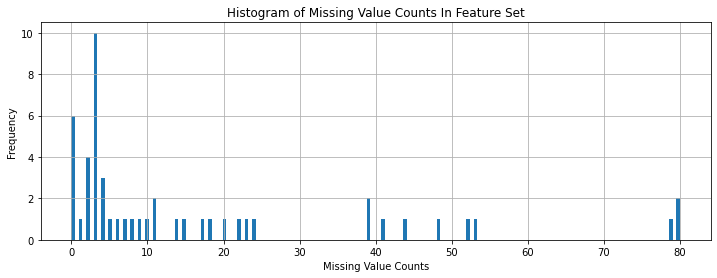

In [14]:
missing_count = td.isnull().sum()
print(type(missing_count))
#Plot a histogram of the missingness observed over all features in the dataset
ax = missing_count.hist(bins=num_rows,figsize=(12,4))
ax.set_xlabel("Missing Value Counts")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Missing Value Counts In Feature Set")

---
# Data Cleaning

### Remove instances (rows) with missing outcome values

In [15]:
print("Number of training instances in original dataset = ",num_rows)
td = td.dropna(axis=0,how='any',subset=[outcomeLabel])
print("Number of training instances after removing instances with missing endpoint = ",len(td))
diff = num_rows-len(td)
print("Number of instances removed = ", diff)
num_rows = len(td) #reassign value (if changed)
if diff > 0:
    data_changed = True
td.shape

Number of training instances in original dataset =  165
Number of training instances after removing instances with missing endpoint =  165
Number of instances removed =  0


(165, 50)

In [16]:
#It's critical to reset the index after dropping rows to work with data frame later with pd.concat of separate columns
td = td.reset_index(drop=True)
td.shape
#Ensure Class variable is cast as an int
td[outcomeLabel] = td[outcomeLabel].astype(dtype='int64')
td.info()

(165, 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Gender                            165 non-null    int64  
 1   Symptoms                          147 non-null    float64
 2   Alcohol                           165 non-null    int64  
 3   Hepatitis B Surface Antigen       148 non-null    float64
 4   Hepatitis B e Antigen             126 non-null    float64
 5   Hepatitis B Core Antibody         141 non-null    float64
 6   Hepatitis C Virus Antibody        156 non-null    float64
 7   Cirrhosis                         165 non-null    int64  
 8   Endemic Countries                 126 non-null    float64
 9   Smoking                           124 non-null    float64
 10  Diabetes                          162 non-null    float64
 11  Obesity                           155 non-null    float64
 12  Hemochro

In [17]:
#Swap class labels (so 0 is majority class)(0's to 1's and 1's to 0's) 
td[outcomeLabel]=td[outcomeLabel].replace(to_replace=0, value=2)
td[outcomeLabel]=td[outcomeLabel].replace(to_replace=1, value=0)
td[outcomeLabel]=td[outcomeLabel].replace(to_replace=2, value=1)

In [18]:
#Confirm no missing values in outcome variable
na_percent = np.sum(td[outcomeLabel].isnull())/len(td[outcomeLabel])*100
if na_percent > 0:
    print(c,'\t\t% Missing(N/A) = ',np.sum(td[outcomeLabel].isnull())/len(td)*100)
else:
    print('No missing values found in: '+ str(outcomeLabel))

No missing values found in: Class Attribute


### Remove columns to be ignored in analysis

In [19]:
print("Number of columns in original dataset = ", num_cols)
td = td.drop(ignore_columns, axis=1)
print("Number of columns after removing ignored columns = ", len(td.columns))
diff = num_cols-len(td.columns)
print("Number of columns removed = ", diff)
num_cols = len(td.columns)
if diff > 0:
    data_changed = True
td.shape

Number of columns in original dataset =  50
Number of columns after removing ignored columns =  50
Number of columns removed =  0


(165, 50)

### Assess class imbalance (assuming discrete outcome)

Counts of each class
1    102
0     63
Name: Class Attribute, dtype: int64


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Class Counts (Checking for Imbalance)')

(165, 50)

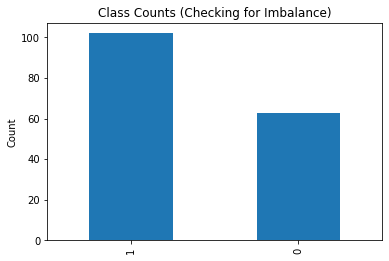

In [20]:
print("Counts of each class")
print(td[outcomeLabel].value_counts())
td[outcomeLabel].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')
td.shape

### Identify categorical variables in dataset

In [21]:
if autoDetectCategorical:
    #Separate independent variables from the rest
    if instLabel == None or instLabel == 'None':
        x_data = td.drop([outcomeLabel], axis=1)
    else:
        x_data = td.drop([outcomeLabel,instLabel], axis=1)

    categorical_variables = identifyCategoricalFeatures(x_data,categoricalCutoff)
    #print(categorical_variables)
    td.shape

(165, 50)

---
# Example Code for other potential data cleaning/processing
- Not applied in this example script, but available here as an example

### Delete Rows/Instances with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [22]:
#num_rows = td.shape[0]
#print("Number of training instances in original dataset = ",num_rows)
#td = td.dropna()
#print("Number of training instances after removing instances with any missing values = ",td.shape[0])
#diff = num_rows-td.shape[0]
#if diff > 0:
#    data_changed = True

### Delete Columns with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [23]:
#num_cols = td.shape[1]
#print("Number of training instances in original dataset = ",num_cols)
#td = df.dropna(axis='columns')
#print("Number of training instances after removing instances with any missing values = ",td.shape[1])
#diff = num_cols-td.shape[1]
#if diff > 0:
#    data_changed = True

### One hot encoding of categorical variables
- Ensures that categorical variables are not treated in an ordinal manner by ML algorithms
- The code below is an example of how to convert a single column to one hot encoding, and is not meant to be run as is. 

In [24]:
## Example below assumes a data frame 'df' with a column called 'B'
#one_hot = pd.get_dummies(df['B'])
#df = df.drop('B',axis = 1)
#df = df.join(one_hot)

### Other possible cleaning steps:
- encode text values as numerics
- oversample or undersample to reduce class imbalance
- drop additional rows based on assigned cutoffs, etc
- cast variable types as nominal or ordinal
- construct missingness features with MissingIndicator: https://scikit-learn.org/stable/modules/impute.html

In [25]:
#Saved for later, determines if imputation attempted.
isMissingData = False
if td.isnull().values.any():
    isMissingData = True

## Save cleaned dataset if it has been modified

In [26]:
if data_changed:
    print('Saving cleaned data.')
    td.shape
    data_name = data_name +'_clean'
    td.to_csv(data_name+'.txt', index=None, sep='\t')

---
# Further Exploratory/Descriptive Analysis
- Visualize feature correlations in data
- Appropriate univariate analyses

## Feature Correlations

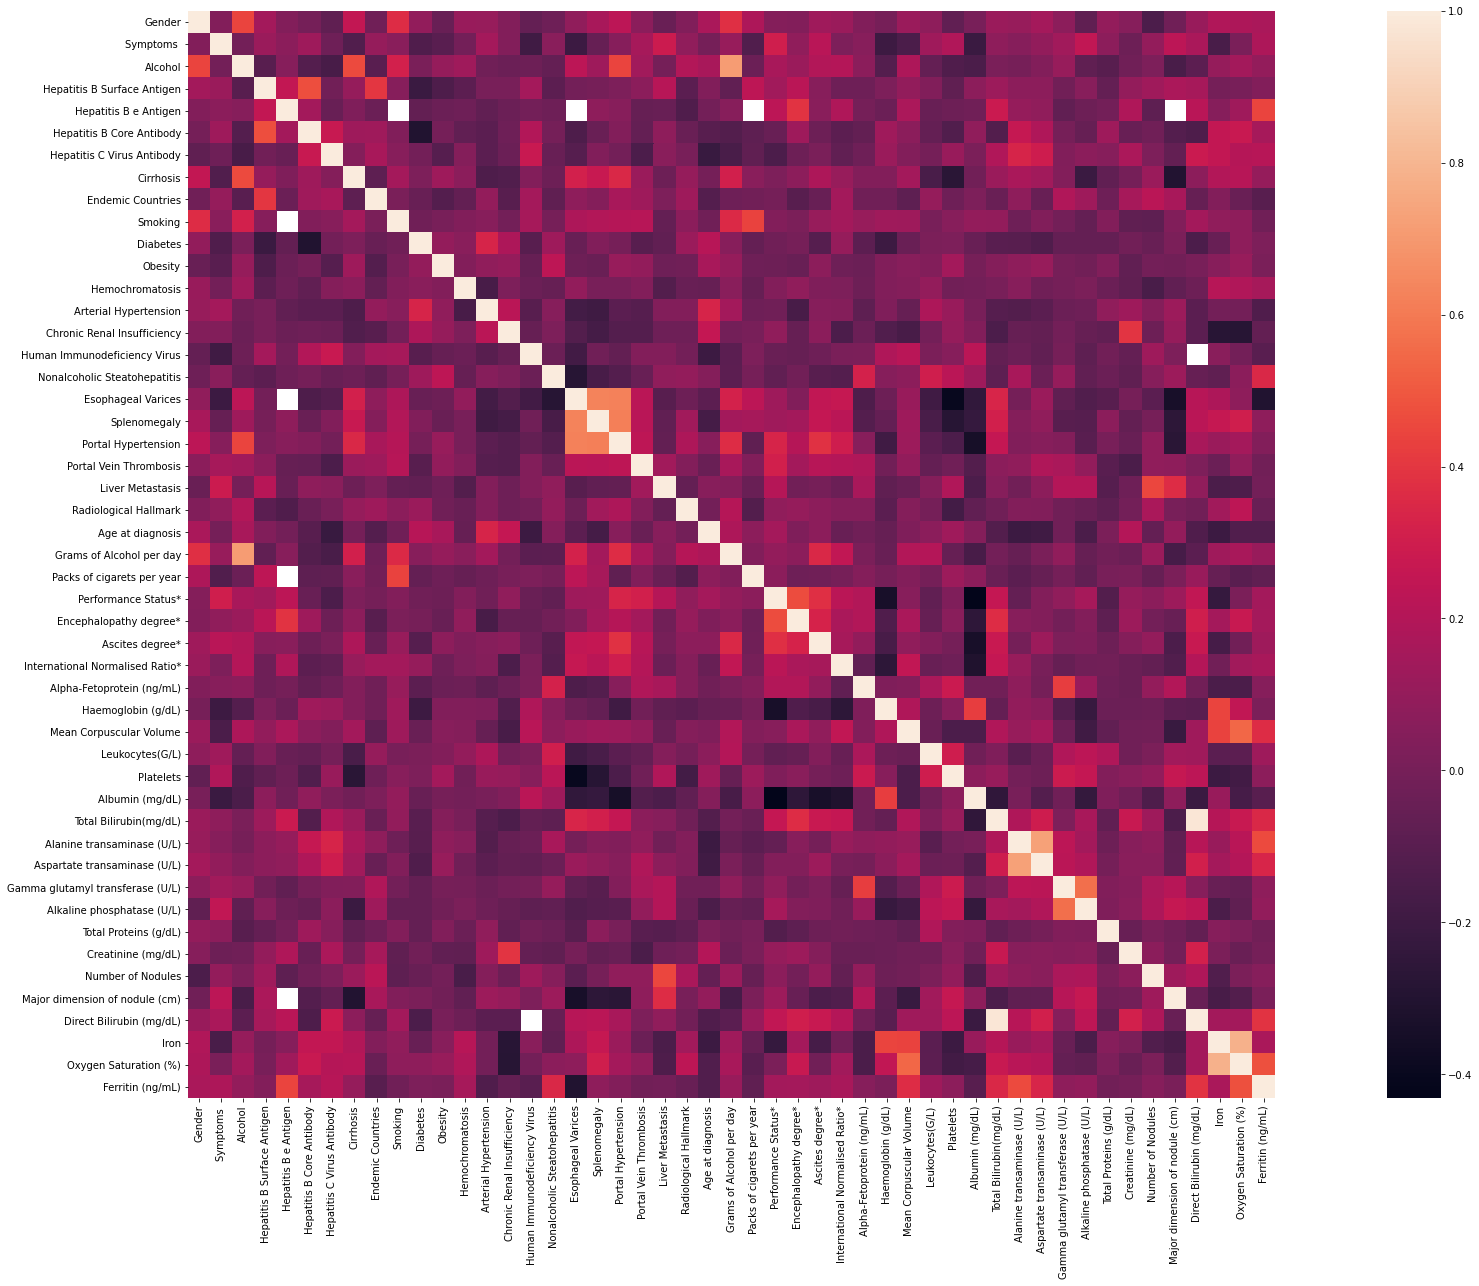

In [27]:
if doCorrelation:
    #Drop outcome column for correlation analysis
    td_cor = td.drop([outcomeLabel], axis=1)
    
    #Compute correlation between the outcome and each feature , excluding NA/null values.
    corrmat = td_cor.corr(method='pearson') 
    f, ax = plt.subplots(figsize = (40,20)) # Note: need large size
    sns.heatmap(corrmat, vmax =1.0,square = True) # Set max value and square-shaped


## Univariate Analysis and Plots
Below we have encoded a method to automatically select an appropriate plot and univariate association test between a single feature and the target outcome in the dataset.

In [28]:
# Code to analyze the univariate relationship between the outcome and each feature
def test_selector(featureName, outcomeLabel, td, categorical_variables):
    p_val = 0
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        
        #Univariate association test (Chi Square Test of Independence - Non-parametric)
        c, p, dof, expected = scs.chi2_contingency(table)
        p_val = p
        
    #Feature is continuous and Outcome is discrete/categorical/binary
    else: 
        #Univariate association test (Mann-Whitney Test - Non-parametric)
        c, p = scs.mannwhitneyu(x=td[featureName].loc[td[outcomeLabel] == 0],y=td[featureName].loc[td[outcomeLabel] == 1])
        p_val = p
        
    return p_val

In [29]:
# Function select appropriate visualizations to examine univariate relationships between each feature and outcome

def graph_selector(featureName, outcomeLabel, td, categorical_variables):
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Generate contingency table count bar plot. ------------------------------------------------------------------------
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        geom_bar_data = pd.DataFrame(table)
        mygraph = geom_bar_data.plot(kind='bar')
        plt.ylabel('Count')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Barplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight",format='png')
        plt.show()
        
    #Feature is continuous and Outcome is discrete/categorical/binary    
    else: 
        #Generate boxplot-----------------------------------------------------------------------------------------------------
        mygraph = td.boxplot(column=featureName,by=outcomeLabel)
        plt.ylabel(featureName)
        plt.title('')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Boxplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight",format='png')
        plt.show()

Plotting top significant 20 features.
###################################################
Significant Univariate Associations:
Alkaline phosphatase (U/L): (p-val = 3.5403912777218106e-06)
Alpha-Fetoprotein (ng/mL): (p-val = 9.073738490213989e-06)
Haemoglobin (g/dL): (p-val = 1.3037749087103508e-05)
Performance Status*: (p-val = 3.2548676278782114e-05)
Albumin (mg/dL): (p-val = 5.377475198115715e-05)
Symptoms : (p-val = 0.0006092985105592953)
Aspartate transaminase (U/L): (p-val = 0.002884797765802902)
Liver Metastasis: (p-val = 0.002993588224869906)
Ascites degree*: (p-val = 0.0038134308539161175)
Iron: (p-val = 0.005998833558788323)
Portal Vein Thrombosis: (p-val = 0.01174304115542567)
Major dimension of nodule (cm): (p-val = 0.014915278309220074)
Age at diagnosis: (p-val = 0.01784161875604351)
Gamma glutamyl transferase (U/L): (p-val = 0.02438867167652392)
Total Proteins (g/dL): (p-val = 0.026093541728036473)
Oxygen Saturation (%): (p-val = 0.026269102572231383)
Encephalopathy degree

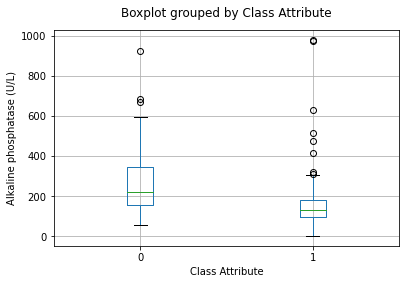

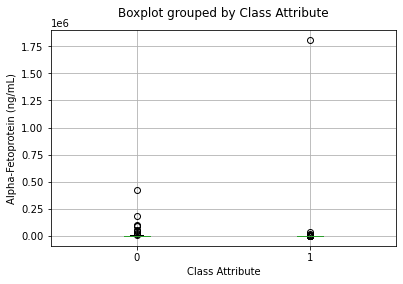

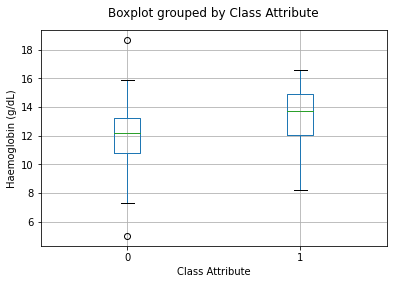

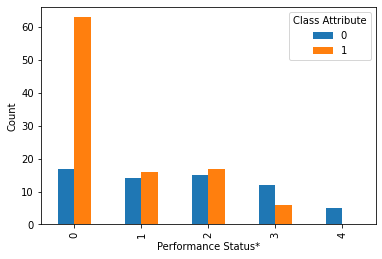

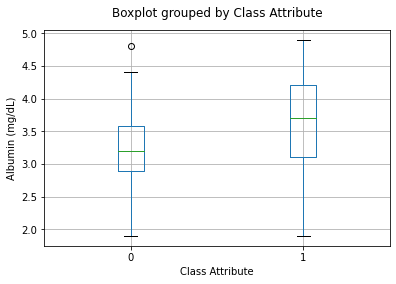

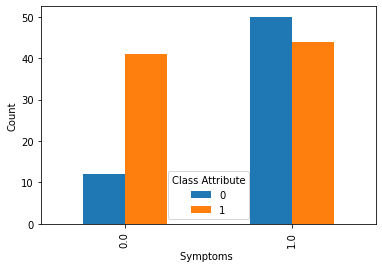

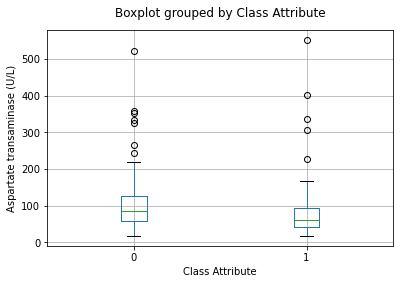

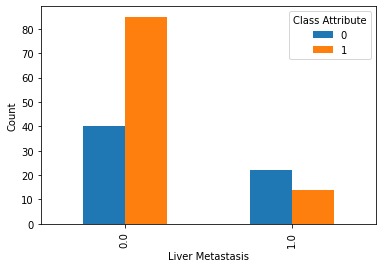

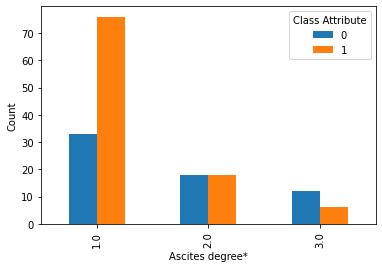

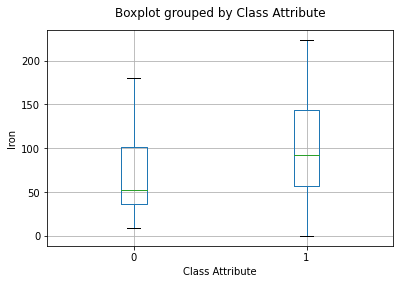

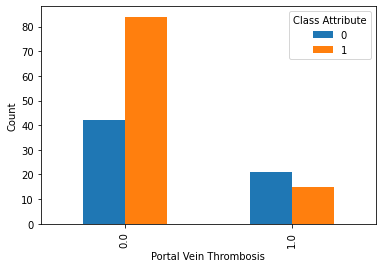

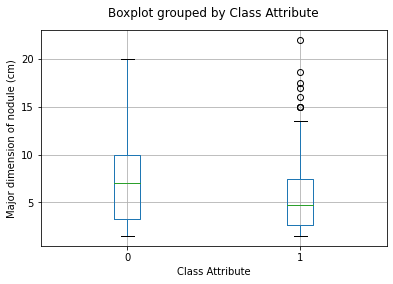

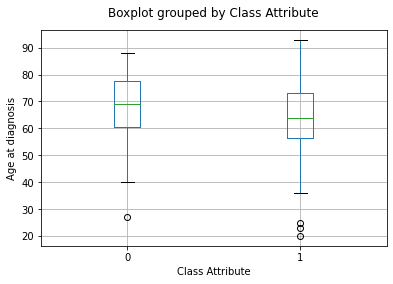

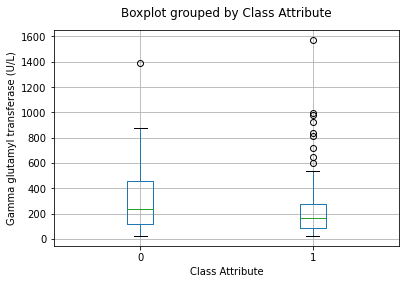

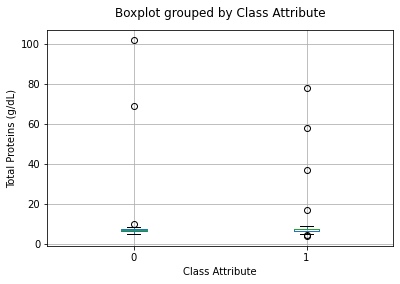

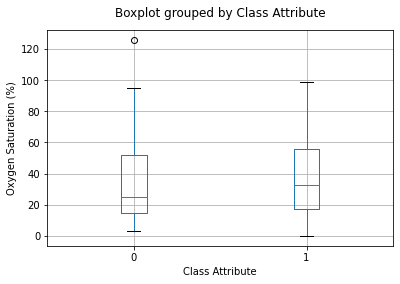

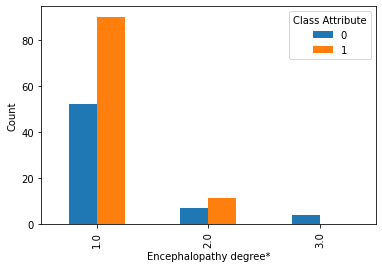

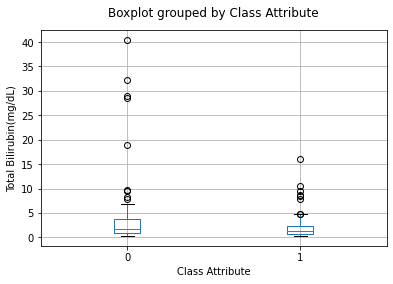

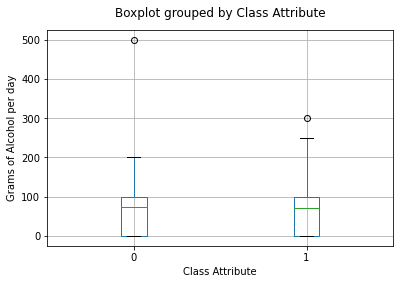

In [30]:
if doUA:
    p_val_dict = {}
    # run appropriate univariate association test for each independent variable
    for each in td:
        if each != outcomeLabel and each != instLabel: 
            p_val_dict[each] = test_selector(each, outcomeLabel, td, categorical_variables)
    
    num_features = td.shape[1] - 1
    
    sorted_p_list = sorted(p_val_dict.items(), key = lambda item:item[1])
    
    #Save all p-values to file
    pval_df = pd.DataFrame.from_dict(p_val_dict, orient='index')
    filepath = wd_path+ua_folder+'/'+'UA_Significance_'+data_name+'.csv'
    pval_df.to_csv(filepath, header=['p-value'], index=True)  
    
    min_num = min(topResults,num_features)
    sorted_p_list = sorted_p_list[: min_num]
    print('Plotting top significant '+ str(min_num) + ' features.')
    
    # summarize significant values of selected number of features
    print('###################################################')
    print('Significant Univariate Associations:')
    for each in sorted_p_list[:min_num]:
        print(each[0]+": (p-val = "+str(each[1]) +")")

    #generate appropriate descriptive plot for selected number of features
    for i in sorted_p_list:
        for j in td:
            if j == i[0]:# if the feature name is within the selected feature list
                graph_selector(j, outcomeLabel, td, categorical_variables) #plot appropriate figure for each feature

---
# Create n-fold Cross Validation (CV) Datasets 
- i.e. Training and Testing Datasets

In [31]:
#Create a header list of independant feature names
header = td.columns.values.tolist()
header.remove(outcomeLabel)
if instLabel != None and instLabel != 'None':
    header.remove(instLabel)

#Perform CV partitioning (get back list of training and testing partition dataframes)
train_dfs, test_dfs = cv_partitioner(td, cv_partitions, partition_method, outcomeLabel, categoricalOutcome, matchName, randomSeed)

if partition_method == 'M':
    header.remove(matchName)

Nominal Stratitifed Partitioning


---
# Transform data - Standard Scaling
- Features are independently scaled to allow them to be more comparable in downstream logistic regression modeling, etc
- Scaling is learned on the training data and saved with pickel so that the same scaling may be applied to any future testing data
- Completed within each training and testing partition independently

In [32]:
if scaleData:
    print('Scaling Data')
    data_name = data_name +'_scale'
    name_path = wd_path+model_folder+'/'+'Scalar_' + data_name+'_'
    train_dfs, test_dfs = dataScaling(train_dfs, test_dfs, outcomeLabel, instLabel, name_path, header)

Scaling Data


---
# Impute Missing Data Values
- Missing data values in categorical features are imputed with simple 'mode' imputation
- Remaining missing data values are imputed using Iterative Imputer (i.e. MICE) 
- Completed within each training and testing partition independently

In [33]:
if imputeData and isMissingData:
    print('Imputing Data')
    data_name = data_name + '_imp'
    train_dfs, test_dfs = imputeCVData(outcomeLabel, instLabel, categorical_variables, header, train_dfs, test_dfs, randomSeed)

Imputing Data


### Confirm Missing Data Imputation

In [34]:
print("Training Datasets")
for each in train_dfs:
    each.isnull().sum().sum()

print("Testing Datasets")
for each in test_dfs:
    each.isnull().sum().sum()

Training Datasets


0

0

0

0

0

0

0

0

0

0

Testing Datasets


0

0

0

0

0

0

0

0

0

0

## Save Training and Testing Datasets as .txt Files

In [35]:
data_name = data_name+'_CV_'+str(partition_method)

counter = 0
for each in train_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Train.txt', index=None, sep='\t')
    counter += 1
    
counter = 0
for each in test_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Test.txt', index=None, sep='\t')
    counter += 1

---
# Load, Check, and Prepare Saved CV Datasets for ML

## Load CV Partition Datasets
Re-loads training and testing datasets from saved .txt files

In [36]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt', na_values='NA', sep = "\t")
    trainList.append(trainSet)
    
    #Load testing partition
    testSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt', na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Testing Partitions: '+ str(len(testList)))

Number of Training Partitions: 10
Number of Testing Partitions: 10


#### Quality Control Check (Checking one of the partitions)
Merge the first training/testing datasets to confirm original dataset is reconstituted

In [37]:
#Confirm case/control counts when merging one training and testing dataset
classesTrain = trainList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTrain = len(classesTrain[classesTrain == True].index)
controlsTrain = len(classesTrain[classesTrain == False].index)

classesTest = testList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTest = len(classesTest[classesTest == True].index)
controlsTest = len(classesTest[classesTest == False].index)

print("Number of Cases in Original Dataset: "+str(casesTrain+casesTest))
print("Number of Controls in Original Dataset: "+str(controlsTrain+controlsTest))

Number of Cases in Original Dataset: 102
Number of Controls in Original Dataset: 63


In [38]:
#Confirm training and testing set dimensions
print("Training Set Dimensions: " + str(trainList[0].shape))
print("Testing Set Dimensions: " + str(testList[0].shape))
numColumns = trainList[0].shape[1]

Training Set Dimensions: (147, 50)
Testing Set Dimensions: (18, 50)


## Partition Data Preprocessing
If present, remove instance id's from datasets prior to analysis. Also confirm that training and testing sets have same set of columns.

In [39]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [40]:
trainColumnNames = list(trainList[0])
testColumnNames = list(testList[0])

if not trainColumnNames == testColumnNames:
    print('Error: Training columns do not match testing columns!')

# As we can see, instLabel is no longer a column name for any of the sets
#print(trainColumnNames)
#print(testColumnNames)

#Create master list of feature names (excluding outcome column)
ordered_feature_names = copy.deepcopy(trainColumnNames) #Stores original ordered feature list 
ordered_feature_names.remove(outcomeLabel)
#ordered_feature_names

## Format data for Scikit learn (separate features from outcome)

In [41]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)

---
# Feature Importance Evaluation
- Completed independently within each training dataset

In [42]:
#Store indexes of 'interesting' features identified by each algorithm in algorithm labeled dictionary
selectedFeatureLists = {}
metaScoreDict = {}
metaFeatureRanks = {}

## Mutual information


Mutual Information Run Time: 1.0647504329681396


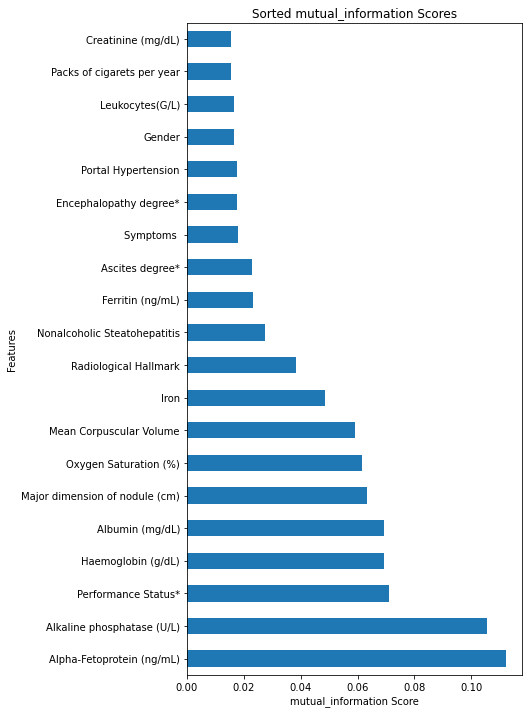

In [43]:
#Run Mutual Information for each CV------------------------------------------------------------------------------
algorithm = 'mutual_information'
if algorithm in algorithms:
    start_time = time.time()
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    featureNameRanks = [] #list of feature name ranks for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_mi(xTrainList[i],yTrainList[i], i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    #cv_output_name = data_name+'_clean_imp_CV_'+partition_method
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks

    elapsed_time = time.time() - start_time
    print('Mutual Information Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## MultiSURF

In [44]:

#Run MultiSURF for each CV------------------------------------------------------------------------------
algorithm = 'multisurf'
if algorithm in algorithms:
    start_time = time.time()
    featureNameRanks = [] ##ADD???
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #If training set is large MultiSURF will run very slowly - quadradic time complexity with # instances (so use subset)
        tempData = pd.concat([pd.DataFrame(yTrainList[i]),pd.DataFrame(xTrainList[i])], axis=1, sort=False)
        if len(tempData) < instanceSubset:
            dataSample = tempData.sample(n=len(tempData), axis = 0)
        else:
            dataSample = tempData.sample(n=instanceSubset, axis = 0)

        xTrain = dataSample.iloc[:, 1:].values
        yTrain = dataSample.iloc[:, 0].values
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_multisurf(xTrain,yTrain, i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks

    elapsed_time = time.time() - start_time
    print('MultiSURF Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time


MultiSURF Run Time: 7.747332572937012


---
# Feature Selection

## Identify union of 'interesting' features from different algorithms
- Operates no matter how many feature selection methods are being applied
- But assumes that all methods have larger scores as being more informative

In [45]:
cv_Selected_List = selectFeatures(algorithms, cv_partitions, selectedFeatureLists, maxFeaturesToKeep,metaFeatureRanks)

### Report counts of 'interesting' features identified by each algorithm

In [46]:
print('Original feature count: '+str(len(ordered_feature_names)))

for each in algorithms:
    print(each)
    for cv in selectedFeatureLists[each]:
        print(len(cv))
    
print("Selected Counts")
for each in cv_Selected_List:
    print(len(each))

Original feature count: 49
mutual_information
29
27
24
24
23
25
30
25
21
24
multisurf
24
21
25
25
25
24
23
20
20
24
Selected Counts
34
35
35
33
35
34
38
34
29
33


## Generate Filtered Datasets (Save as new .txt files)
- These datasets included only the selected features for each respective partition
- Note that the feature order from the original datasets is no longer preserved in these datasets

In [47]:
if filterPoorFeatures:
    genFilteredDatasets(cv_Selected_List, outcomeLabel, instLabel,cv_partitions,cv_data_folder,data_name)
    data_name = data_name +'_FS'

## Generate Filtered MultiSURF Files (Save as new .txt files)

In [48]:
if 'multisurf' in algorithms: #This method is only meant for working with MultiSURF scores
    if filterPoorFeatures:
        for i in range(cv_partitions):
            tempDict = scoreDictSet[i]

            #create new dictionary with only selected features
            scoreDict = {}
            for j in cv_Selected_List[i]:
                scoreDict[j] = tempDict[j]
            
            filename = output_folder+'/'+'multisurf'+'_'+data_name+'_'+str(i)+'_Train.txt'
            sort_save_fs_fi_scores(scoreDict, 'multisurf', filename)

---
# Load, Check, and Prepare Filtered CV Datasets for ML
- If user opted not to filter datasets then the code below will simply reload the original CV datasets again.

## Load CV Partition Datasets (Filtered Datasets)

In [49]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt'
    trainSet = pd.read_csv(trainset_name, na_values='NA', sep = "\t")
    trainList.append(trainSet)

    #Load testing partition
    testset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt'
    testSet = pd.read_csv(testset_name, na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Testing Partitions: '+ str(len(testList)))

Number of Training Partitions: 10
Number of Testing Partitions: 10


## CV partition data cleaning (Filtered Datasets)

In [50]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [51]:
global_ordered_features = [] #Holds the new order of features in the FS CV datasets
for i in range(cv_partitions):
    cv_ordered_features = list(trainList[i])
    cv_ordered_features.remove(outcomeLabel)
    #print(cv_ordered_features)
    global_ordered_features.append(cv_ordered_features)

## Format data for Scikit learn (filtered datasets)

In [52]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)


---
# Machine Learning Modeling
ML algorithms are run one after the other below. Within each we conduct a hyperparameter sweep, train a best model and evaluate it indendently within each CV training/testing partition. 
- All standard classification metrics are computed for the resulting models as well as an ROC curve and precision/recall curve

## Run Logistic Regression

Running logistic_regression
Best trial:
  Value:  0.766053574797208
  Params: 
    penalty: l2
    dual: False
    C: 0.0003630322466779861
    solver: liblinear
    class_weight: None
    max_iter: 539.948440978743
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6995849839652895
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.7050619379991195
  Params: 
    penalty: l2
    dual: False
    C: 0.0003630322466779861
    solver: liblinear
    class_weight: None
    max_iter: 539.948440978743
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6851443123938878
  Params: 
    penalty: l2
    dual: False
    C: 0.0003630322466779861
    solver: liblinear
    class_weight: None
    max_iter: 539.948440978743
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.7048481418600264
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6980569703829467
  Params: 
    penalty: l2
    dual: False
    C: 69.5553059264574
    solver: sag
    class_weight: None
    max_iter: 165.95613641357252
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.7091209205810225
  Params: 
    penalty: l2
    dual: False
    C: 0.0003630322466779861
    solver: liblinear
    class_weight: None
    max_iter: 539.948440978743
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6720524429352951
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6905206564799095
  Params: 
    penalty: l1
    dual: False
    C: 120.4275297251682
    solver: saga
    class_weight: balanced
    max_iter: 277.9697551526682
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.7132616487455197
  Params: 
    penalty: l2
    dual: False
    C: 32147.193482816965
    solver: liblinear
    class_weight: balanced
    max_iter: 157.51320499779712
    n_jobs: -1


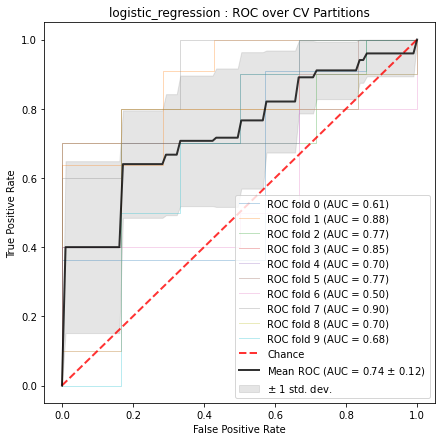

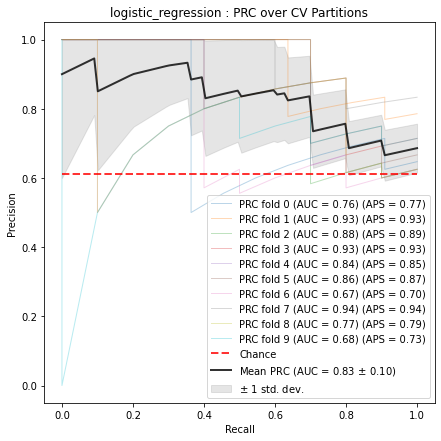

Avg. Model Balanced Accuracy = 0.6564718614718614 (std. dev. = 0.1123825469807293)
Avg. Model Accuracy = 0.6688725490196078 (std. dev. = 0.10451246588638376)
Avg. Model F1-Score = 0.7248370927318295 (std. dev. = 0.09257925875982098)
Avg. Model Recall = 0.7081818181818182 (std. dev. = 0.09503805240512182)
Avg. Model Specificity = 0.6047619047619047 (std. dev. = 0.15872222202379963)
Avg. Model Precision = 0.7452525252525253 (std. dev. = 0.09931589282021717)
Avg. Model True Positives = 7.2 (std. dev. = 0.8717797887081347)
Avg. Model True Negatives = 3.8 (std. dev. = 0.9797958971132712)
Avg. Model False Positives = 2.5 (std. dev. = 1.02469507659596)
Avg. Model False Negatives = 3.0 (std. dev. = 1.0954451150103321)
Avg. ROC AUC = 0.7364935064935065 (std. dev. = 0.11856151048514896)
Avg. PRC AUC = 0.8266320436841827 (std. dev. = 0.09522419517106817)
Avg. PRC Precision Score = 0.8402643623459131 (std. dev. = 0.08347757460326169)

---Feature Importances---



Names    Scores
8                Endemic Countries  0.031667
31              Haemoglobin (g/dL)  0.026667
40      Alkaline phosphatase (U/L)  0.026667
1                        Symptoms   0.026667
16    Nonalcoholic Steatohepatitis  0.021667
44  Major dimension of nodule (cm)  0.020476
28                 Ascites degree*  0.020000
0                           Gender  0.018333
38    Aspartate transaminase (U/L)  0.018333
26             Performance Status*  0.018333
10                        Diabetes  0.015000
47           Oxygen Saturation (%)  0.013333
21                Liver Metastasis  0.013333
20          Portal Vein Thrombosis  0.013333
24        Grams of Alcohol per day  0.013333
35                 Albumin (mg/dL)  0.010000
36          Total Bilirubin(mg/dL)  0.010000
19             Portal Hypertension  0.010000
23                Age at diagnosis  0.009545
22           Radiological Hallmark  0.008333

Logistic Regression Run Time: 33.75689101219177


In [53]:
algorithm = 'logistic_regression'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Logistic Regression Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Decision Tree

Running decision_tree
Best trial:
  Value:  0.7119631516066152
  Params: 
    criterion: gini
    splitter: best
    max_depth: 12
    min_samples_split: 10
    min_samples_leaf: 20
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.7231843048481418
  Params: 
    criterion: entropy
    splitter: best
    max_depth: 23
    min_samples_split: 11
    min_samples_leaf: 48
    max_features: None
    class_weight: None
Running decision_tree
Best trial:
  Value:  0.6712601395963026
  Params: 
    criterion: gini
    splitter: random
    max_depth: 29
    min_samples_split: 16
    min_samples_leaf: 43
    max_features: None
    class_weight: None
Running decision_tree
Best trial:
  Value:  0.7190530088662516
  Params: 
    criterion: gini
    splitter: random
    max_depth: 21
    min_samples_split: 13
    min_samples_leaf: 9
    max_features: auto
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.6837011884550085
  Params: 


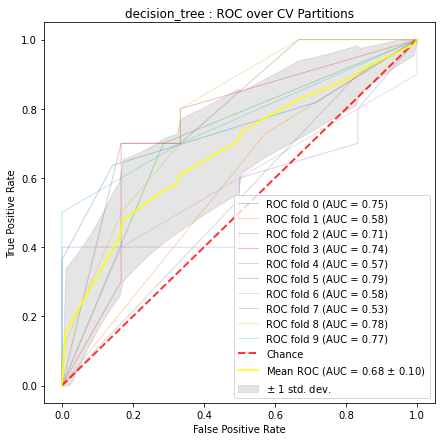

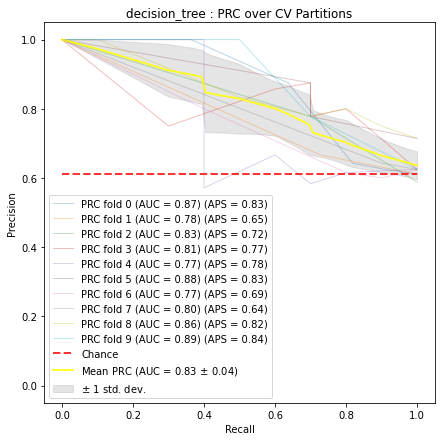

Avg. Model Balanced Accuracy = 0.6481818181818182 (std. dev. = 0.09747352876642826)
Avg. Model Accuracy = 0.660171568627451 (std. dev. = 0.06242825830386521)
Avg. Model F1-Score = 0.7164696160691583 (std. dev. = 0.04134806138136373)
Avg. Model Recall = 0.6963636363636364 (std. dev. = 0.10230403561189237)
Avg. Model Specificity = 0.6 (std. dev. = 0.267854497341433)
Avg. Model Precision = 0.7674908424908424 (std. dev. = 0.11683120371082022)
Avg. Model True Positives = 7.1 (std. dev. = 1.0440306508910548)
Avg. Model True Negatives = 3.8 (std. dev. = 1.7204650534085253)
Avg. Model False Positives = 2.5 (std. dev. = 1.6278820596099706)
Avg. Model False Negatives = 3.1 (std. dev. = 1.0440306508910548)
Avg. ROC AUC = 0.6790151515151515 (std. dev. = 0.09769575232476042)
Avg. PRC AUC = 0.8253810135942491 (std. dev. = 0.044116585216750444)
Avg. PRC Precision Score = 0.7571691755956461 (std. dev. = 0.07247871375317073)

---Feature Importances---



Names    Scores
26               Performance Status*  0.204597
30         Alpha-Fetoprotein (ng/mL)  0.161549
35                   Albumin (mg/dL)  0.152528
46                              Iron  0.131427
48                  Ferritin (ng/mL)  0.097081
1                          Symptoms   0.048806
21                  Liver Metastasis  0.043338
40        Alkaline phosphatase (U/L)  0.029314
19               Portal Hypertension  0.025677
29   International Normalised Ratio*  0.012635
33                   Leukocytes(G/L)  0.011449
20            Portal Vein Thrombosis  0.010388
31                Haemoglobin (g/dL)  0.009229
10                          Diabetes  0.008948
38      Aspartate transaminase (U/L)  0.008582
14       Chronic Renal Insufficiency  0.007849
39  Gamma glutamyl transferase (U/L)  0.007655
44    Major dimension of nodule (cm)  0.007263
45          Direct Bilirubin (mg/dL)  0.006196
27            Encephalopathy degree*  0.005733

Decision Tree Run Time: 14.325530290603638


In [54]:
algorithm = 'decision_tree'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
    
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Decision Tree Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Random Forest

Running random_forest
Best trial:
  Value:  0.7744670816827014
  Params: 
    n_estimators: 444
    criterion: entropy
    max_depth: 13
    min_samples_split: 27
    min_samples_leaf: 17
    max_features: log2
    bootstrap: True
    oob_score: True
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.7595233603722568
  Params: 
    n_estimators: 796
    criterion: entropy
    max_depth: 6
    min_samples_split: 14
    min_samples_leaf: 16
    max_features: auto
    bootstrap: True
    oob_score: True
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.7347701691504748
  Params: 
    n_estimators: 524
    criterion: entropy
    max_depth: 20
    min_samples_split: 13
    min_samples_leaf: 12
    max_features: log2
    bootstrap: True
    oob_score: True
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.7399358611582721
  Params: 
    n_estimators: 885
    criterion: entropy
   

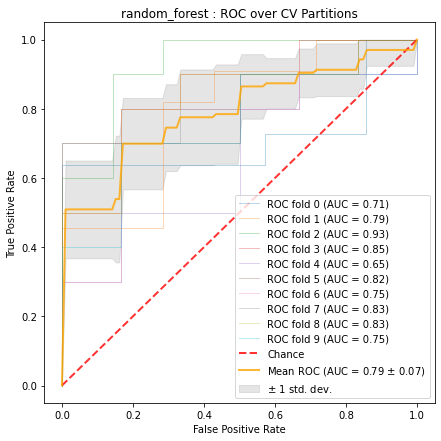

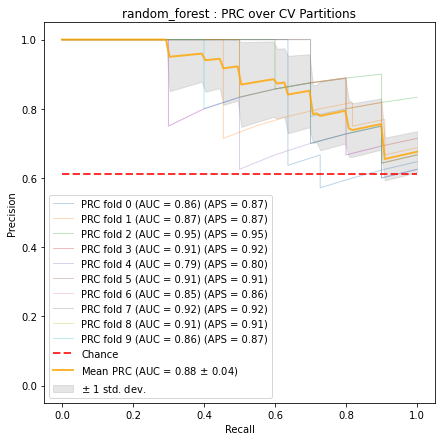

Avg. Model Balanced Accuracy = 0.7186796536796537 (std. dev. = 0.07521226435766167)
Avg. Model Accuracy = 0.7209150326797386 (std. dev. = 0.06807933542440603)
Avg. Model F1-Score = 0.7623946229209387 (std. dev. = 0.057662021408845764)
Avg. Model Recall = 0.7254545454545455 (std. dev. = 0.0717894073541805)
Avg. Model Specificity = 0.7119047619047618 (std. dev. = 0.12619047619047621)
Avg. Model Precision = 0.8081565656565657 (std. dev. = 0.06963921721581297)
Avg. Model True Positives = 7.4 (std. dev. = 0.8)
Avg. Model True Negatives = 4.5 (std. dev. = 0.9219544457292888)
Avg. Model False Positives = 1.8 (std. dev. = 0.7483314773547883)
Avg. Model False Negatives = 2.8 (std. dev. = 0.7483314773547882)
Avg. ROC AUC = 0.7918398268398268 (std. dev. = 0.07468091139149616)
Avg. PRC AUC = 0.8820410084567838 (std. dev. = 0.04245354961455786)
Avg. PRC Precision Score = 0.888024970424703 (std. dev. = 0.03992323971560861)

---Feature Importances---



Names    Scores
30         Alpha-Fetoprotein (ng/mL)  0.135368
40        Alkaline phosphatase (U/L)  0.105829
31                Haemoglobin (g/dL)  0.100602
35                   Albumin (mg/dL)  0.088491
26               Performance Status*  0.059915
48                  Ferritin (ng/mL)  0.059478
46                              Iron  0.042126
45          Direct Bilirubin (mg/dL)  0.041536
44    Major dimension of nodule (cm)  0.035116
38      Aspartate transaminase (U/L)  0.035015
39  Gamma glutamyl transferase (U/L)  0.033873
47             Oxygen Saturation (%)  0.029461
41             Total Proteins (g/dL)  0.023705
23                  Age at diagnosis  0.021725
33                   Leukocytes(G/L)  0.021529
29   International Normalised Ratio*  0.019370
36            Total Bilirubin(mg/dL)  0.019295
28                   Ascites degree*  0.017682
32           Mean Corpuscular Volume  0.016588
1                          Symptoms   0.015925

Random Forest Run Time: 1570.7634029388428


In [55]:
algorithm = 'random_forest'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Random Forest Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Naive Bayes

Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes


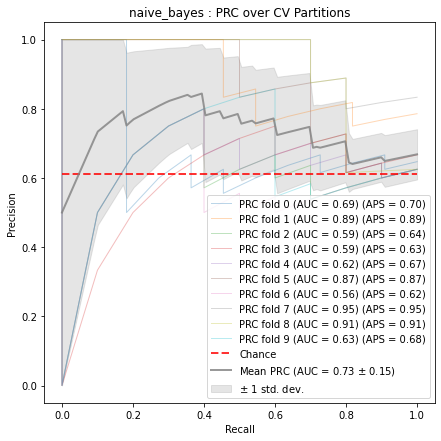

Avg. Model Balanced Accuracy = 0.64008658008658 (std. dev. = 0.12765795573636382)
Avg. Model Accuracy = 0.6678513071895426 (std. dev. = 0.1087923433326607)
Avg. Model F1-Score = 0.7377857745969202 (std. dev. = 0.08021837587723539)
Avg. Model Recall = 0.7563636363636363 (std. dev. = 0.1063131193166816)
Avg. Model Specificity = 0.5238095238095237 (std. dev. = 0.2404644032943352)
Avg. Model Precision = 0.7317460317460317 (std. dev. = 0.10225324489760572)
Avg. Model True Positives = 7.7 (std. dev. = 1.004987562112089)
Avg. Model True Negatives = 3.3 (std. dev. = 1.4866068747318506)
Avg. Model False Positives = 3.0 (std. dev. = 1.4832396974191326)
Avg. Model False Negatives = 2.5 (std. dev. = 1.118033988749895)
Avg. ROC AUC = 0.6352813852813852 (std. dev. = 0.16313205345766238)
Avg. PRC AUC = 0.7299404108220953 (std. dev. = 0.14679571302602676)
Avg. PRC Precision Score = 0.7578341259156767 (std. dev. = 0.12640450257207003)

---Feature Importances---



Names    Scores
45         Direct Bilirubin (mg/dL)  0.037424
26              Performance Status*  0.034762
27           Encephalopathy degree*  0.031234
20           Portal Vein Thrombosis  0.025476
36           Total Bilirubin(mg/dL)  0.024545
25       Packs of cigarets per year  0.024091
28                  Ascites degree*  0.022879
29  International Normalised Ratio*  0.020476
21                 Liver Metastasis  0.015931
38     Aspartate transaminase (U/L)  0.013333
14      Chronic Renal Insufficiency  0.012143
44   Major dimension of nodule (cm)  0.012143
48                 Ferritin (ng/mL)  0.010000
40       Alkaline phosphatase (U/L)  0.009545
30        Alpha-Fetoprotein (ng/mL)  0.008333
46                             Iron  0.008333
35                  Albumin (mg/dL)  0.008333
0                            Gender  0.008333
8                 Endemic Countries  0.008333
16     Nonalcoholic Steatohepatitis  0.008333

Naive Bayes Run Time: 1.272792100906372


In [56]:
algorithm = 'naive_bayes'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Naive Bayes Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run XGBoost

Running XGB
Best trial:
  Value:  0.7710714959441615
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 3.213461665761482e-07
    alpha: 0.004602928786281603
    eta: 2.00322884659305e-08
    gamma: 0.0002290194871061189
    max_depth: 30
    grow_policy: lossguide
    n_estimators: 307
    min_samples_split: 13
    min_samples_leaf: 2
    subsample: 0.6855865338530786
    min_child_weight: 0.9953109685404578
    colsample_bytree: 0.355079740152254
    scale_pos_weight: 0.6153846153846154



Running XGB
Best trial:
  Value:  0.7599603848330503
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.011691028244187
    alpha: 0.0004813586888966231
    eta: 2.9039701791454627e-08
    gamma: 1.9160590267907568e-08
    max_depth: 13
    grow_policy: lossguide
    n_estimators: 341
    min_samples_split: 38
    min_samples_leaf: 39
    subsample: 0.5103073128992787
    min_child_weight: 0.32885373055772316
    colsample_bytree: 0.5460537169044187
    scale_pos_weight: 0.6153846153846154



Running XGB
Best trial:
  Value:  0.7339244167767087
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.2938658102493286
    alpha: 0.00978978158192176
    eta: 5.659913155079017e-06
    gamma: 4.4024397699170575e-07
    max_depth: 30
    grow_policy: depthwise
    n_estimators: 949
    min_samples_split: 20
    min_samples_leaf: 8
    subsample: 0.6547612701336132
    min_child_weight: 2.5175627337578383
    colsample_bytree: 0.10095715239922064
    scale_pos_weight: 0.6086956521739131



Running XGB
Best trial:
  Value:  0.7345595170722504
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.025103723378396132
    alpha: 2.1340833150845283e-05
    eta: 0.003896212073093522
    gamma: 4.181583656844983e-07
    max_depth: 4
    grow_policy: depthwise
    n_estimators: 353
    min_samples_split: 35
    min_samples_leaf: 2
    subsample: 0.8284046130819692
    min_child_weight: 3.574943583239086
    colsample_bytree: 0.13900497439705434
    scale_pos_weight: 0.6195652173913043



Running XGB
Best trial:
  Value:  0.7884267119411431
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.0036558403481672715
    alpha: 9.125576572855505e-08
    eta: 0.15355079206658223
    gamma: 0.07197162463949916
    max_depth: 1
    grow_policy: depthwise
    n_estimators: 943
    min_samples_split: 27
    min_samples_leaf: 14
    subsample: 0.7020665052010719
    min_child_weight: 6.900394874437407
    colsample_bytree: 0.2216811979287109
    scale_pos_weight: 0.6195652173913043



Running XGB
Best trial:
  Value:  0.7483493680437654
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 9.734885936484496e-07
    alpha: 9.020213913184812e-08
    eta: 0.0012045709261143975
    gamma: 5.221811478665047e-05
    max_depth: 21
    grow_policy: depthwise
    n_estimators: 353
    min_samples_split: 14
    min_samples_leaf: 34
    subsample: 0.784319786411839
    min_child_weight: 3.7541217889880207
    colsample_bytree: 0.1707127683306989
    scale_pos_weight: 0.6195652173913043



Running XGB
Best trial:
  Value:  0.6996793057913601
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 5.23869460292723e-07
    alpha: 5.3512113331763e-06
    eta: 9.088160636894758e-07
    gamma: 0.13691410931031245
    max_depth: 3
    grow_policy: depthwise
    n_estimators: 43
    min_samples_split: 33
    min_samples_leaf: 36
    subsample: 0.8661953281889871
    min_child_weight: 0.11684183431468753
    colsample_bytree: 0.19938440475197433
    scale_pos_weight: 0.6195652173913043



Running XGB
Best trial:
  Value:  0.7340218826636483
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.004660979349669028
    alpha: 1.0195861759531687e-08
    eta: 2.1277332545494437e-06
    gamma: 9.558305842130314e-05
    max_depth: 4
    grow_policy: lossguide
    n_estimators: 437
    min_samples_split: 23
    min_samples_leaf: 6
    subsample: 0.7613785802804781
    min_child_weight: 2.331964249708972
    colsample_bytree: 0.2843202879117272
    scale_pos_weight: 0.6195652173913043



Running XGB
Best trial:
  Value:  0.721156385587625
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.0235204919428519
    alpha: 6.509834329174245e-07
    eta: 0.04674283493379956
    gamma: 0.0007960592845739464
    max_depth: 21
    grow_policy: lossguide
    n_estimators: 726
    min_samples_split: 44
    min_samples_leaf: 45
    subsample: 0.8678521171517648
    min_child_weight: 1.550325852870369
    colsample_bytree: 0.7358396012353583
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.747783437087342
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.0005599239781417117
    alpha: 0.002851113461638951
    eta: 0.0001409591829636835
    gamma: 6.150613459044183e-07
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 309
    min_samples_split: 43
    min_samples_leaf: 21
    subsample: 0.6393093837750284
    min_child_weight: 0.18742721341939622
    colsample_bytree: 0.18520751615671294
    scale_pos_weight: 0.6195652173913043


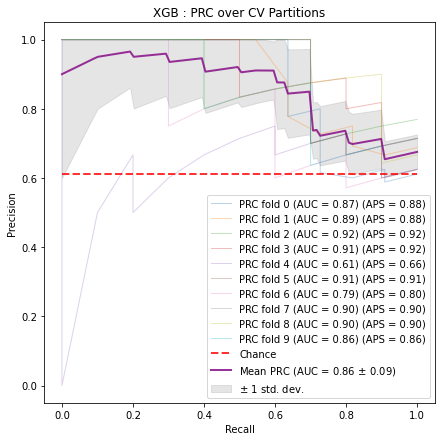

Avg. Model Balanced Accuracy = 0.668939393939394 (std. dev. = 0.08450900868688546)
Avg. Model Accuracy = 0.6775326797385621 (std. dev. = 0.07248237827210972)
Avg. Model F1-Score = 0.7301273003480568 (std. dev. = 0.05627871310673942)
Avg. Model Recall = 0.7045454545454545 (std. dev. = 0.06671141748711759)
Avg. Model Specificity = 0.6333333333333333 (std. dev. = 0.14990548798759235)
Avg. Model Precision = 0.7632395382395382 (std. dev. = 0.07495955173646517)
Avg. Model True Positives = 7.2 (std. dev. = 0.8717797887081347)
Avg. Model True Negatives = 4.0 (std. dev. = 1.0)
Avg. Model False Positives = 2.3 (std. dev. = 0.9)
Avg. Model False Negatives = 3.0 (std. dev. = 0.6324555320336759)
Avg. ROC AUC = 0.762056277056277 (std. dev. = 0.09477109282097634)
Avg. PRC AUC = 0.8560493114283221 (std. dev. = 0.08862506691570474)
Avg. PRC Precision Score = 0.8648306012169649 (std. dev. = 0.07489571780118404)

---Feature Importances---



Names    Scores
40        Alkaline phosphatase (U/L)  0.044307
26               Performance Status*  0.034307
30         Alpha-Fetoprotein (ng/mL)  0.032619
35                   Albumin (mg/dL)  0.028831
36            Total Bilirubin(mg/dL)  0.027165
48                  Ferritin (ng/mL)  0.022619
25        Packs of cigarets per year  0.020022
1                          Symptoms   0.020022
44    Major dimension of nodule (cm)  0.017879
47             Oxygen Saturation (%)  0.015476
45          Direct Bilirubin (mg/dL)  0.012879
37        Alanine transaminase (U/L)  0.012143
33                   Leukocytes(G/L)  0.011688
21                  Liver Metastasis  0.011688
20            Portal Vein Thrombosis  0.011688
19               Portal Hypertension  0.011688
31                Haemoglobin (g/dL)  0.011688
9                            Smoking  0.011688
46                              Iron  0.010000
39  Gamma glutamyl transferase (U/L)  0.010000

XGBoost Run Time: 341.6104199886322


In [57]:
algorithm = 'XGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('XGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run LGBoost

Running LGB
Best trial:
  Value:  0.7663616927623719
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 69
    max_depth: 29
    lambda_l1: 5.062102733604366e-05
    lambda_l2: 2.412393622424711e-07
    feature_fraction: 0.666659219027543
    bagging_fraction: 0.405078061694548
    bagging_freq: 3
    min_child_samples: 13
    n_estimators: 93
    scale_pos_weight: 0.6153846153846154



Running LGB
Best trial:
  Value:  0.7677262151795259
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 228
    max_depth: 19
    lambda_l1: 7.922446497675504e-06
    lambda_l2: 0.0022306439808357555
    feature_fraction: 0.5787367433688786
    bagging_fraction: 0.7881633161131407
    bagging_freq: 3
    min_child_samples: 9
    n_estimators: 49
    scale_pos_weight: 0.6153846153846154



Running LGB
Best trial:
  Value:  0.73824435641074
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 217
    max_depth: 13
    lambda_l1: 2.427695010769642e-08
    lambda_l2: 1.909146677761742e-06
    feature_fraction: 0.9364731154184596
    bagging_fraction: 0.9626069318715369
    bagging_freq: 3
    min_child_samples: 16
    n_estimators: 810
    scale_pos_weight: 0.6086956521739131



Running LGB
Best trial:
  Value:  0.6910582908885118
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 240
    max_depth: 11
    lambda_l1: 9.692280420809054e-08
    lambda_l2: 2.982008785336304
    feature_fraction: 0.6532670204505017
    bagging_fraction: 0.7316094128767996
    bagging_freq: 3
    min_child_samples: 34
    n_estimators: 632
    scale_pos_weight: 0.6195652173913043



Running LGB
Best trial:
  Value:  0.7619788719109603
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 29
    max_depth: 22
    lambda_l1: 0.0016499746656720566
    lambda_l2: 0.48981752759597535
    feature_fraction: 0.42928727738401795
    bagging_fraction: 0.9804643631312101
    bagging_freq: 6
    min_child_samples: 41
    n_estimators: 183
    scale_pos_weight: 0.6195652173913043



Running LGB
Best trial:
  Value:  0.6922939068100359
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 14
    max_depth: 22
    lambda_l1: 0.00404602972651073
    lambda_l2: 0.0001844786696291353
    feature_fraction: 0.7039533914934467
    bagging_fraction: 0.8424504616670256
    bagging_freq: 6
    min_child_samples: 33
    n_estimators: 25
    scale_pos_weight: 0.6195652173913043



Running LGB
Best trial:
  Value:  0.7216468590831919
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 187
    max_depth: 25
    lambda_l1: 2.718720134497197e-05
    lambda_l2: 0.00027021807757442976
    feature_fraction: 0.5306582246128203
    bagging_fraction: 0.7200020198377183
    bagging_freq: 4
    min_child_samples: 27
    n_estimators: 134
    scale_pos_weight: 0.6195652173913043



Running LGB
Best trial:
  Value:  0.7007074136955292
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 136
    max_depth: 20
    lambda_l1: 0.007023093282028783
    lambda_l2: 0.34438672346610694
    feature_fraction: 0.44384828271343585
    bagging_fraction: 0.9150680380517958
    bagging_freq: 1
    min_child_samples: 45
    n_estimators: 462
    scale_pos_weight: 0.6195652173913043



Running LGB
Best trial:
  Value:  0.7397566496887379
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 89
    max_depth: 21
    lambda_l1: 0.002570603566117598
    lambda_l2: 0.023585940584142682
    feature_fraction: 0.41235069657748147
    bagging_fraction: 0.9819459112971965
    bagging_freq: 4
    min_child_samples: 34
    n_estimators: 815
    scale_pos_weight: 0.6195652173913043



Running LGB
Best trial:
  Value:  0.6851443123938878
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 92
    max_depth: 18
    lambda_l1: 0.020178012690323092
    lambda_l2: 0.007568380314808164
    feature_fraction: 0.6544627432135235
    bagging_fraction: 0.9904005107086076
    bagging_freq: 4
    min_child_samples: 32
    n_estimators: 610
    scale_pos_weight: 0.6195652173913043


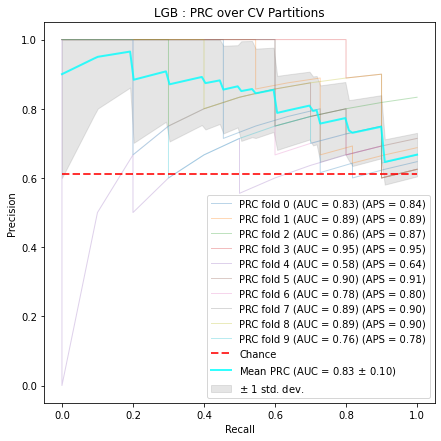

Avg. Model Balanced Accuracy = 0.6589177489177489 (std. dev. = 0.1004013049271342)
Avg. Model Accuracy = 0.6726715686274509 (std. dev. = 0.09216541796438922)
Avg. Model F1-Score = 0.7282775119617225 (std. dev. = 0.08106688755748834)
Avg. Model Recall = 0.7154545454545455 (std. dev. = 0.10445054980885406)
Avg. Model Specificity = 0.6023809523809524 (std. dev. = 0.16871194036244644)
Avg. Model Precision = 0.7493434343434343 (std. dev. = 0.0837919123973537)
Avg. Model True Positives = 7.3 (std. dev. = 1.1)
Avg. Model True Negatives = 3.8 (std. dev. = 1.0770329614269007)
Avg. Model False Positives = 2.5 (std. dev. = 1.02469507659596)
Avg. Model False Negatives = 2.9 (std. dev. = 1.044030650891055)
Avg. ROC AUC = 0.746969696969697 (std. dev. = 0.10809745718561244)
Avg. PRC AUC = 0.8350775262319381 (std. dev. = 0.09915664115822442)
Avg. PRC Precision Score = 0.8473514949103184 (std. dev. = 0.08571272103284018)

---Feature Importances---



Names    Scores
48                  Ferritin (ng/mL)  0.048831
30         Alpha-Fetoprotein (ng/mL)  0.036667
32           Mean Corpuscular Volume  0.027165
10                          Diabetes  0.025022
40        Alkaline phosphatase (U/L)  0.025022
25        Packs of cigarets per year  0.023831
31                Haemoglobin (g/dL)  0.023074
23                  Age at diagnosis  0.022424
17                Esophageal Varices  0.021429
47             Oxygen Saturation (%)  0.021234
38      Aspartate transaminase (U/L)  0.020000
45          Direct Bilirubin (mg/dL)  0.019286
20            Portal Vein Thrombosis  0.019286
14       Chronic Renal Insufficiency  0.018831
0                             Gender  0.018831
26               Performance Status*  0.018810
27            Encephalopathy degree*  0.016883
28                   Ascites degree*  0.016688
39  Gamma glutamyl transferase (U/L)  0.016667
44    Major dimension of nodule (cm)  0.015022

LGBoost Run Time: 218.37586760520935


In [58]:
algorithm = 'LGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
        
    elapsed_time = time.time() - start_time
    print('LGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run SVM

Running SVM
Best trial:
  Value:  0.7891026850279822
  Params: 
    kernel: rbf
    C: 2.583297522601289
    gamma: scale
    degree: 6
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.7034175941646229
  Params: 
    kernel: rbf
    C: 6.6723671704642005
    gamma: scale
    degree: 6
    probability: True
    class_weight: None



Running SVM
Best trial:
  Value:  0.7543985411557568
  Params: 
    kernel: rbf
    C: 0.16153391174779966
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6952839086964723
  Params: 
    kernel: rbf
    C: 0.15394318841697496
    gamma: scale
    degree: 1
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.7445199019053007
  Params: 
    kernel: rbf
    C: 0.15242112460420734
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.7014525561214864
  Params: 
    kernel: linear
    C: 6.053058219348386
    gamma: scale
    degree: 6
    probability: True
    class_weight: None



Running SVM
Best trial:
  Value:  0.7321448783248443
  Params: 
    kernel: rbf
    C: 0.3275070275526715
    gamma: scale
    degree: 4
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.7181286549707603
  Params: 
    kernel: rbf
    C: 0.20632553421843053
    gamma: scale
    degree: 4
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.7318336162988115
  Params: 
    kernel: rbf
    C: 0.6463079598617195
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.7222127900396152
  Params: 
    kernel: linear
    C: 12.84588946430048
    gamma: scale
    degree: 5
    probability: True
    class_weight: balanced


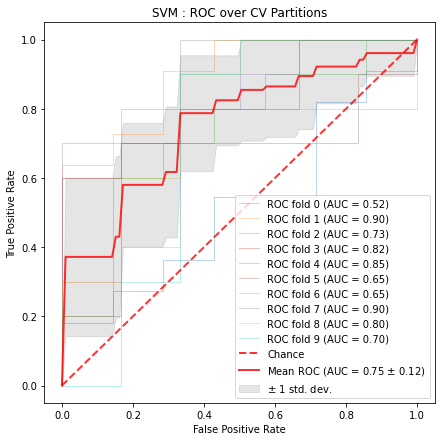

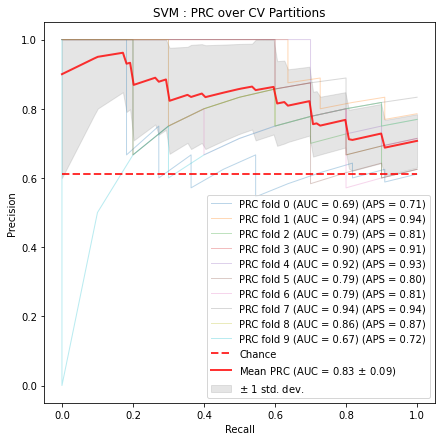

Avg. Model Balanced Accuracy = 0.6784632034632034 (std. dev. = 0.06792870285179055)
Avg. Model Accuracy = 0.660171568627451 (std. dev. = 0.07048325536399384)
Avg. Model F1-Score = 0.6796091189512241 (std. dev. = 0.08178489112027813)
Avg. Model Recall = 0.6045454545454545 (std. dev. = 0.15256755718085097)
Avg. Model Specificity = 0.7523809523809524 (std. dev. = 0.17502834237608672)
Avg. Model Precision = 0.818968253968254 (std. dev. = 0.10798461229647191)
Avg. Model True Positives = 6.2 (std. dev. = 1.7776388834631178)
Avg. Model True Negatives = 4.7 (std. dev. = 1.004987562112089)
Avg. Model False Positives = 1.6 (std. dev. = 1.2)
Avg. Model False Negatives = 4.0 (std. dev. = 1.5491933384829668)
Avg. ROC AUC = 0.751082251082251 (std. dev. = 0.11699465577519887)
Avg. PRC AUC = 0.8290368869840794 (std. dev. = 0.09326854623392508)
Avg. PRC Precision Score = 0.8422395483304573 (std. dev. = 0.08258333301781379)

---Feature Importances---



Names    Scores
26             Performance Status*  0.048095
28                 Ascites degree*  0.045952
21                Liver Metastasis  0.034762
1                        Symptoms   0.026429
10                        Diabetes  0.025952
35                 Albumin (mg/dL)  0.025476
40      Alkaline phosphatase (U/L)  0.017143
20          Portal Vein Thrombosis  0.015476
32         Mean Corpuscular Volume  0.015476
9                          Smoking  0.014286
31              Haemoglobin (g/dL)  0.013333
27          Encephalopathy degree*  0.012143
19             Portal Hypertension  0.012143
48                Ferritin (ng/mL)  0.010476
23                Age at diagnosis  0.009545
44  Major dimension of nodule (cm)  0.009545
47           Oxygen Saturation (%)  0.008333
41           Total Proteins (g/dL)  0.008333
42              Creatinine (mg/dL)  0.008333
37      Alanine transaminase (U/L)  0.007143

SVM Run Time: 43.635889291763306


In [59]:
algorithm = 'SVM'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('SVM Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run ANN

Running ANN
Best trial:
  Value:  0.7578978809029744
  Params: 
    activation: tanh
    learning_rate: constant
    momentum: 0.6336918493673647
    solver: adam
    batch_size: auto
    alpha: 0.0009344057486726259
    max_iter: 200
    n_layers: 1
    n_units_l0: 43



Running ANN
Best trial:
  Value:  0.7237376595610892
  Params: 
    activation: logistic
    learning_rate: adaptive
    momentum: 0.4490419143917245
    solver: adam
    batch_size: auto
    alpha: 0.005811742646598273
    max_iter: 200
    n_layers: 2
    n_units_l0: 88
    n_units_l1: 30



Running ANN
Best trial:
  Value:  0.7515657423127712
  Params: 
    activation: relu
    learning_rate: adaptive
    momentum: 0.8290091882698244
    solver: adam
    batch_size: auto
    alpha: 0.0008013945955992161
    max_iter: 200
    n_layers: 3
    n_units_l0: 19
    n_units_l1: 29
    n_units_l2: 55



Running ANN
Best trial:
  Value:  0.6943218260705528
  Params: 
    activation: tanh
    learning_rate: adaptive
    momentum: 0.5812121043875266
    solver: adam
    batch_size: auto
    alpha: 0.005845798584197883
    max_iter: 200
    n_layers: 2
    n_units_l0: 39
    n_units_l1: 85



Running ANN
Best trial:
  Value:  0.7420958309752876
  Params: 
    activation: tanh
    learning_rate: invscaling
    momentum: 0.6769808234327012
    solver: adam
    batch_size: auto
    alpha: 0.03226328032261577
    max_iter: 200
    n_layers: 1
    n_units_l0: 31



Running ANN
Best trial:
  Value:  0.721156385587625
  Params: 
    activation: identity
    learning_rate: adaptive
    momentum: 0.5030839884010527
    solver: adam
    batch_size: auto
    alpha: 0.004014706873893623
    max_iter: 200
    n_layers: 1
    n_units_l0: 11



Running ANN
Best trial:
  Value:  0.7304942463686097
  Params: 
    activation: logistic
    learning_rate: adaptive
    momentum: 0.886935749663177
    solver: adam
    batch_size: auto
    alpha: 0.0032686836914011023
    max_iter: 200
    n_layers: 1
    n_units_l0: 8



Running ANN
Best trial:
  Value:  0.6720996038483306
  Params: 
    activation: relu
    learning_rate: constant
    momentum: 0.615866007475385
    solver: adam
    batch_size: auto
    alpha: 0.00014748369193800322
    max_iter: 200
    n_layers: 1
    n_units_l0: 28



Running ANN
Best trial:
  Value:  0.7128749292586304
  Params: 
    activation: logistic
    learning_rate: constant
    momentum: 0.33964483511557164
    solver: adam
    batch_size: auto
    alpha: 0.027929028312922304
    max_iter: 200
    n_layers: 3
    n_units_l0: 83
    n_units_l1: 99
    n_units_l2: 15



Running ANN
Best trial:
  Value:  0.7231371439351065
  Params: 
    activation: tanh
    learning_rate: constant
    momentum: 0.5006443496933953
    solver: adam
    batch_size: auto
    alpha: 0.012575851502194965
    max_iter: 200
    n_layers: 3
    n_units_l0: 20
    n_units_l1: 79
    n_units_l2: 9


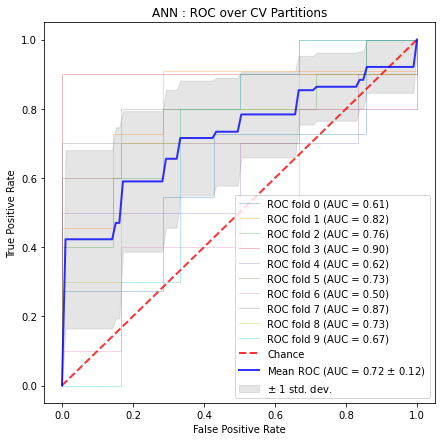

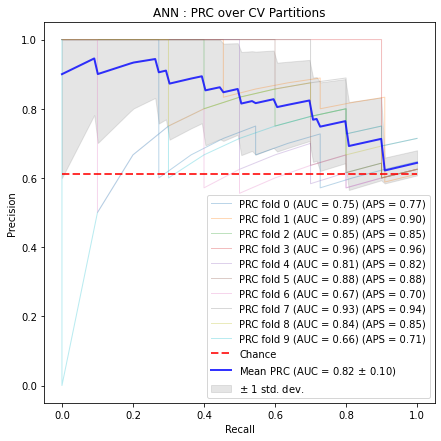

Avg. Model Balanced Accuracy = 0.6781818181818182 (std. dev. = 0.09895993113876975)
Avg. Model Accuracy = 0.6973039215686274 (std. dev. = 0.09018882584273127)
Avg. Model F1-Score = 0.7547041847041847 (std. dev. = 0.0752593096821505)
Avg. Model Recall = 0.7563636363636365 (std. dev. = 0.09278073325216785)
Avg. Model Specificity = 0.6 (std. dev. = 0.15714285714285717)
Avg. Model Precision = 0.7581060606060606 (std. dev. = 0.07814572957305507)
Avg. Model True Positives = 7.7 (std. dev. = 0.9)
Avg. Model True Negatives = 3.8 (std. dev. = 1.0770329614269007)
Avg. Model False Positives = 2.5 (std. dev. = 0.9219544457292888)
Avg. Model False Negatives = 2.5 (std. dev. = 1.02469507659596)
Avg. ROC AUC = 0.7202380952380952 (std. dev. = 0.11799238143381487)
Avg. PRC AUC = 0.82433509026624 (std. dev. = 0.09717581529670094)
Avg. PRC Precision Score = 0.8372206232567194 (std. dev. = 0.08531531676341618)

---Feature Importances---



Names    Scores
40        Alkaline phosphatase (U/L)  0.076429
16      Nonalcoholic Steatohepatitis  0.059286
32           Mean Corpuscular Volume  0.057641
30         Alpha-Fetoprotein (ng/mL)  0.055498
28                   Ascites degree*  0.052143
46                              Iron  0.050498
31                Haemoglobin (g/dL)  0.050476
19               Portal Hypertension  0.049286
26               Performance Status*  0.049264
1                          Symptoms   0.048074
33                   Leukocytes(G/L)  0.045952
44    Major dimension of nodule (cm)  0.043810
21                  Liver Metastasis  0.040216
36            Total Bilirubin(mg/dL)  0.038810
20            Portal Vein Thrombosis  0.037338
10                          Diabetes  0.035952
48                  Ferritin (ng/mL)  0.035216
14       Chronic Renal Insufficiency  0.033355
39  Gamma glutamyl transferase (U/L)  0.033355
35                   Albumin (mg/dL)  0.032879

ANN Run Time: 381.6807744503021


In [60]:
algorithm = 'ANN'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('ANN Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run eLCS

Running eLCS
Running eLCS
Running eLCS
Running eLCS
Running eLCS
Running eLCS
Running eLCS
Running eLCS
Running eLCS
Running eLCS



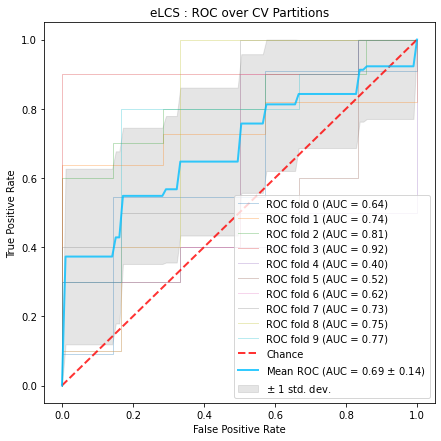

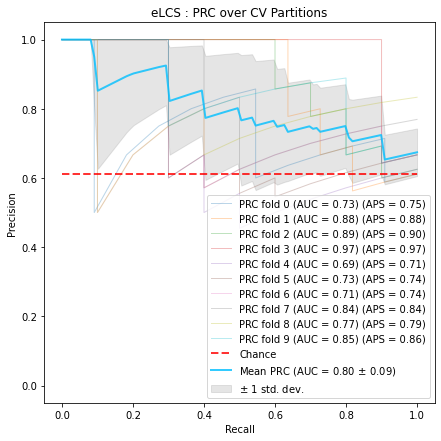

Avg. Model Balanced Accuracy = 0.6211038961038962 (std. dev. = 0.1488123258295818)
Avg. Model Accuracy = 0.6674428104575163 (std. dev. = 0.1326767515218834)
Avg. Model F1-Score = 0.7514736788764249 (std. dev. = 0.10181426851054187)
Avg. Model Recall = 0.8136363636363637 (std. dev. = 0.1219842829599625)
Avg. Model Specificity = 0.42857142857142855 (std. dev. = 0.24490268324997697)
Avg. Model Precision = 0.7047496947496947 (std. dev. = 0.10639152573784758)
Avg. Model True Positives = 8.3 (std. dev. = 1.268857754044952)
Avg. Model True Negatives = 2.7 (std. dev. = 1.5524174696260025)
Avg. Model False Positives = 3.6 (std. dev. = 1.562049935181331)
Avg. Model False Negatives = 1.9 (std. dev. = 1.2206555615733703)
Avg. ROC AUC = 0.6890909090909091 (std. dev. = 0.14251215066209783)
Avg. PRC AUC = 0.8044627747475342 (std. dev. = 0.08835216523244803)
Avg. PRC Precision Score = 0.8172883952055076 (std. dev. = 0.08150734484929992)

---Feature Importances---



Names  Scores
10                      Diabetes  1050.6
28               Ascites degree*  1027.8
19           Portal Hypertension   987.5
21              Liver Metastasis   983.5
20        Portal Vein Thrombosis   885.6
27        Encephalopathy degree*   868.1
16  Nonalcoholic Steatohepatitis   857.8
14   Chronic Renal Insufficiency   840.5
26           Performance Status*   822.1
1                      Symptoms    764.7
43             Number of Nodules   677.1
32       Mean Corpuscular Volume   617.5
0                         Gender   610.0
47         Oxygen Saturation (%)   576.5
30     Alpha-Fetoprotein (ng/mL)   571.1
8              Endemic Countries   558.6
25    Packs of cigarets per year   557.9
35               Albumin (mg/dL)   554.9
40    Alkaline phosphatase (U/L)   554.3
36        Total Bilirubin(mg/dL)   549.8

eLCS Run Time: 11048.459250450134


In [61]:
algorithm = 'eLCS'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,lcs_timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('eLCS Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run XCS

Running XCS
Running XCS
Running XCS
Running XCS
Running XCS
Running XCS
Running XCS
Running XCS
Running XCS
Running XCS



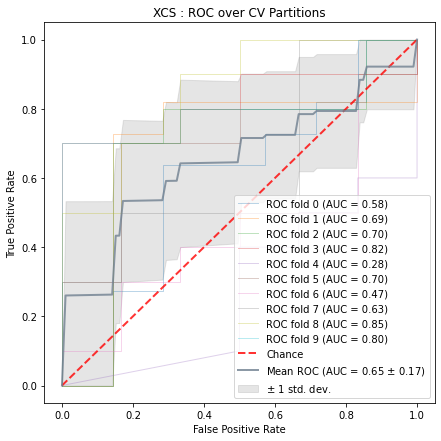

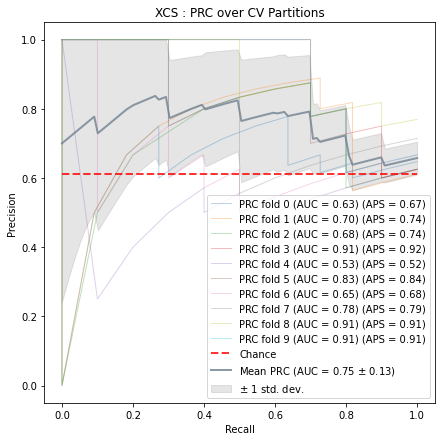

Avg. Model Balanced Accuracy = 0.615108225108225 (std. dev. = 0.12612852577786884)
Avg. Model Accuracy = 0.6417483660130718 (std. dev. = 0.10963766153499198)
Avg. Model F1-Score = 0.7158794714057871 (std. dev. = 0.07845173346357164)
Avg. Model Recall = 0.7254545454545455 (std. dev. = 0.08457966072445826)
Avg. Model Specificity = 0.5047619047619049 (std. dev. = 0.20420744421325301)
Avg. Model Precision = 0.7108974358974358 (std. dev. = 0.09084696814522)
Avg. Model True Positives = 7.4 (std. dev. = 0.9165151389911681)
Avg. Model True Negatives = 3.2 (std. dev. = 1.32664991614216)
Avg. Model False Positives = 3.1 (std. dev. = 1.2206555615733703)
Avg. Model False Negatives = 2.8 (std. dev. = 0.8717797887081347)
Avg. ROC AUC = 0.651439393939394 (std. dev. = 0.16599399059796724)
Avg. PRC AUC = 0.7520311955572649 (std. dev. = 0.12873402935690448)
Avg. PRC Precision Score = 0.7716190675040943 (std. dev. = 0.12301300670382484)

---Feature Importances---



Names  Scores
10                      Diabetes   862.8
26           Performance Status*   838.2
28               Ascites degree*   834.6
21              Liver Metastasis   723.1
19           Portal Hypertension   713.7
20        Portal Vein Thrombosis   648.9
43             Number of Nodules   591.0
1                      Symptoms    589.3
14   Chronic Renal Insufficiency   580.6
27        Encephalopathy degree*   463.4
16  Nonalcoholic Steatohepatitis   420.9
0                         Gender   403.4
22         Radiological Hallmark   356.0
6     Hepatitis C Virus Antibody   353.3
8              Endemic Countries   345.5
32       Mean Corpuscular Volume   302.7
40    Alkaline phosphatase (U/L)   285.3
36        Total Bilirubin(mg/dL)   284.4
41         Total Proteins (g/dL)   272.0
5      Hepatitis B Core Antibody   256.2

XCS Run Time: 5706.974658489227


In [62]:
algorithm = 'XCS'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,lcs_timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('XCS Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run ExSTraCS 2.0

Running ExSTraCS
Running ExSTraCS
Running ExSTraCS
Running ExSTraCS
Running ExSTraCS
Running ExSTraCS
Running ExSTraCS
Running ExSTraCS
Running ExSTraCS
Running ExSTraCS



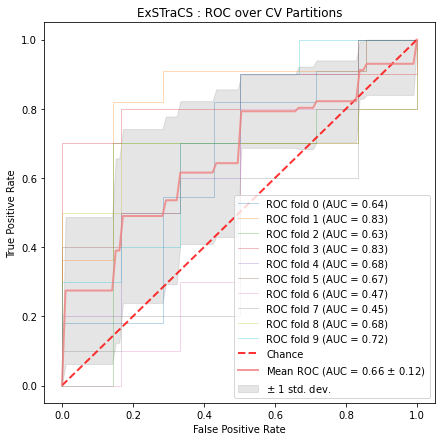

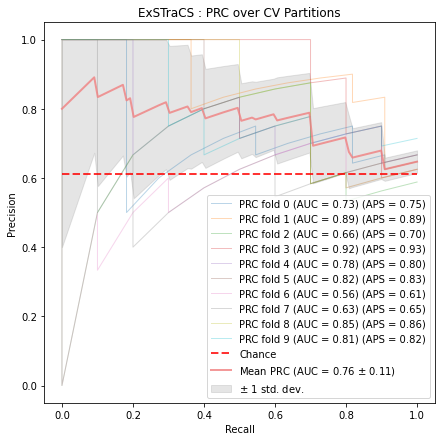

Avg. Model Balanced Accuracy = 0.6252813852813853 (std. dev. = 0.10980666041042175)
Avg. Model Accuracy = 0.6550245098039216 (std. dev. = 0.10105390967932094)
Avg. Model F1-Score = 0.7227492683502914 (std. dev. = 0.10374649693451572)
Avg. Model Recall = 0.7481818181818183 (std. dev. = 0.14625066221507207)
Avg. Model Specificity = 0.5023809523809524 (std. dev. = 0.22295937825922799)
Avg. Model Precision = 0.7176631701631702 (std. dev. = 0.09685101656427642)
Avg. Model True Positives = 7.6 (std. dev. = 1.42828568570857)
Avg. Model True Negatives = 3.2 (std. dev. = 1.5362291495737217)
Avg. Model False Positives = 3.1 (std. dev. = 1.374772708486752)
Avg. Model False Negatives = 2.6 (std. dev. = 1.6248076809271923)
Avg. ROC AUC = 0.6596103896103896 (std. dev. = 0.121124048089471)
Avg. PRC AUC = 0.7647757779208314 (std. dev. = 0.11295495678684508)
Avg. PRC Precision Score = 0.7845015389393731 (std. dev. = 0.09786737322096833)

---Feature Importances---



Names  Scores
26             Performance Status*   541.9
21                Liver Metastasis   408.4
28                 Ascites degree*   374.8
10                        Diabetes   353.0
31              Haemoglobin (g/dL)   285.9
20          Portal Vein Thrombosis   263.1
35                 Albumin (mg/dL)   254.6
40      Alkaline phosphatase (U/L)   254.6
14     Chronic Renal Insufficiency   249.7
44  Major dimension of nodule (cm)   243.9
23                Age at diagnosis   224.9
43               Number of Nodules   218.4
32         Mean Corpuscular Volume   205.5
47           Oxygen Saturation (%)   202.0
46                            Iron   195.9
33                 Leukocytes(G/L)   182.4
48                Ferritin (ng/mL)   178.1
27          Encephalopathy degree*   174.4
41           Total Proteins (g/dL)   168.6
19             Portal Hypertension   164.1

ExSTraCS 2.0 Run Time: 8445.04454088211


In [63]:
algorithm = 'ExSTraCS'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,lcs_timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('ExSTraCS 2.0 Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run ExSTraCS 2.0 with QRF

Running ExSTraCS_QRF
Running ExSTraCS_QRF
Running ExSTraCS_QRF
Running ExSTraCS_QRF
Running ExSTraCS_QRF
Running ExSTraCS_QRF
Running ExSTraCS_QRF
Running ExSTraCS_QRF
Running ExSTraCS_QRF
Running ExSTraCS_QRF



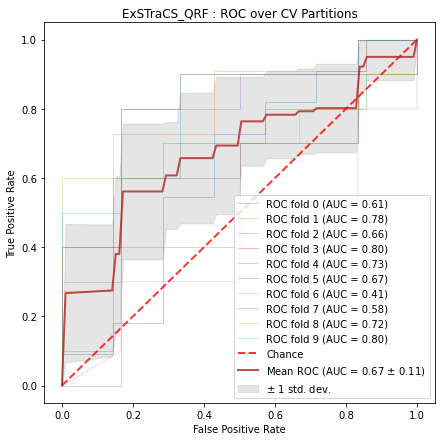

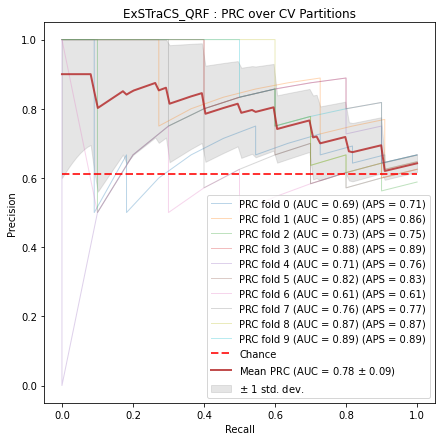

Avg. Model Balanced Accuracy = 0.5639177489177489 (std. dev. = 0.063592841523834)
Avg. Model Accuracy = 0.6258578431372549 (std. dev. = 0.0644119040837388)
Avg. Model F1-Score = 0.7281122822427171 (std. dev. = 0.0623873055428445)
Avg. Model Recall = 0.8254545454545454 (std. dev. = 0.12256217851892887)
Avg. Model Specificity = 0.30238095238095236 (std. dev. = 0.16079803814193375)
Avg. Model Precision = 0.6596978021978022 (std. dev. = 0.04714924722097703)
Avg. Model True Positives = 8.4 (std. dev. = 1.2)
Avg. Model True Negatives = 1.9 (std. dev. = 1.044030650891055)
Avg. Model False Positives = 4.4 (std. dev. = 1.1135528725660042)
Avg. Model False Negatives = 1.8 (std. dev. = 1.32664991614216)
Avg. ROC AUC = 0.675508658008658 (std. dev. = 0.11459711414801758)
Avg. PRC AUC = 0.7799141830762819 (std. dev. = 0.0905917894433177)
Avg. PRC Precision Score = 0.7945462026090369 (std. dev. = 0.08638821430737001)

---Feature Importances---



Names  Scores
26             Performance Status*   411.5
21                Liver Metastasis   319.6
28                 Ascites degree*   270.2
10                        Diabetes   259.4
31              Haemoglobin (g/dL)   224.1
35                 Albumin (mg/dL)   204.9
40      Alkaline phosphatase (U/L)   203.9
20          Portal Vein Thrombosis   196.3
44  Major dimension of nodule (cm)   188.0
14     Chronic Renal Insufficiency   181.1
23                Age at diagnosis   170.6
43               Number of Nodules   160.1
47           Oxygen Saturation (%)   158.1
32         Mean Corpuscular Volume   149.9
46                            Iron   146.0
48                Ferritin (ng/mL)   134.8
27          Encephalopathy degree*   133.8
33                 Leukocytes(G/L)   132.6
30       Alpha-Fetoprotein (ng/mL)   123.3
25      Packs of cigarets per year   117.6

ExSTraCS 2.0 with QRF Run Time: 9.861414909362793


In [64]:
algorithm = 'ExSTraCS_QRF'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,lcs_timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('ExSTraCS 2.0 with QRF Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Gradient Boosting Classifier

Running gradient_boosting
Best trial:
  Value:  0.7288027416210777
  Params: 
    loss: exponential
    learning_rate: 0.16891215579189656
    min_samples_leaf: 20
    max_depth: 3
    n_iter_no_change: 6
    validation_fraction: 0.25
Running gradient_boosting
Best trial:
  Value:  0.7425957366534616
  Params: 
    loss: exponential
    learning_rate: 0.5393700916606459
    min_samples_leaf: 16
    max_depth: 3
    n_iter_no_change: 7
    validation_fraction: 0.13
Running gradient_boosting
Best trial:
  Value:  0.712805759919512
  Params: 
    loss: exponential
    learning_rate: 0.5445874464452625
    min_samples_leaf: 20
    max_depth: 7
    n_iter_no_change: 19
    validation_fraction: 0.08
Running gradient_boosting
Best trial:
  Value:  0.6688832295793246
  Params: 
    loss: deviance
    learning_rate: 0.5679693384344885
    min_samples_leaf: 42
    max_depth: 10
    n_iter_no_change: 12
    validation_fraction: 0.09999999999999999
Running gradient_boosting
Best trial:
  Value:  0

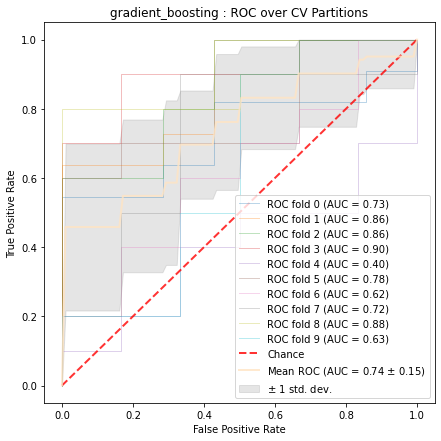

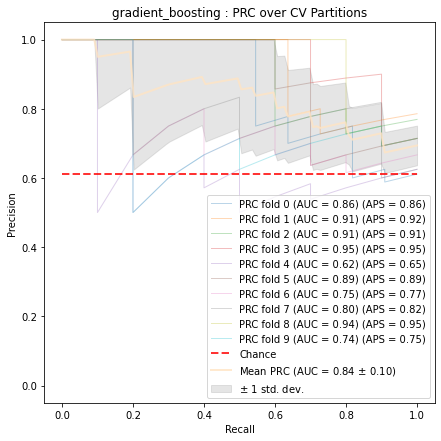

Avg. Model Balanced Accuracy = 0.6341774891774892 (std. dev. = 0.11485817901039137)
Avg. Model Accuracy = 0.6729983660130718 (std. dev. = 0.09394256996188932)
Avg. Model F1-Score = 0.7525608883869754 (std. dev. = 0.06070889629333741)
Avg. Model Recall = 0.7945454545454546 (std. dev. = 0.050321281829447465)
Avg. Model Specificity = 0.4738095238095238 (std. dev. = 0.20576994396964254)
Avg. Model Precision = 0.7180969030969031 (std. dev. = 0.08205294516093808)
Avg. Model True Positives = 8.1 (std. dev. = 0.5385164807134504)
Avg. Model True Negatives = 3.0 (std. dev. = 1.3416407864998738)
Avg. Model False Positives = 3.3 (std. dev. = 1.268857754044952)
Avg. Model False Negatives = 2.1 (std. dev. = 0.5385164807134505)
Avg. ROC AUC = 0.7374891774891775 (std. dev. = 0.1477495836505149)
Avg. PRC AUC = 0.8368878277100202 (std. dev. = 0.10163715715811276)
Avg. PRC Precision Score = 0.8469486775850411 (std. dev. = 0.09346571694966246)

---Feature Importances---



Names    Scores
30        Alpha-Fetoprotein (ng/mL)  0.263690
31               Haemoglobin (g/dL)  0.094805
48                 Ferritin (ng/mL)  0.090732
26              Performance Status*  0.061706
46                             Iron  0.054297
35                  Albumin (mg/dL)  0.051801
40       Alkaline phosphatase (U/L)  0.050049
23                 Age at diagnosis  0.037931
47            Oxygen Saturation (%)  0.033478
32          Mean Corpuscular Volume  0.033059
44   Major dimension of nodule (cm)  0.031943
29  International Normalised Ratio*  0.027022
37       Alanine transaminase (U/L)  0.021583
45         Direct Bilirubin (mg/dL)  0.021409
33                  Leukocytes(G/L)  0.021387
36           Total Bilirubin(mg/dL)  0.019114
38     Aspartate transaminase (U/L)  0.017054
41            Total Proteins (g/dL)  0.015063
25       Packs of cigarets per year  0.013233
42               Creatinine (mg/dL)  0.012244

Gradient Boosting Classifier Run Time: 36.40423250198364


In [65]:
algorithm = 'gradient_boosting'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('Gradient Boosting Classifier Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run K-Neighbors Classifier

Running k_neighbors
Best trial:
  Value:  0.7127051499717035
  Params: 
    n_neighbors: 6
    weights: uniform
    p: 1
    metric: minkowski



Running k_neighbors
Best trial:
  Value:  0.7070709928944224
  Params: 
    n_neighbors: 4
    weights: uniform
    p: 1
    metric: minkowski



Running k_neighbors
Best trial:
  Value:  0.7052663019556059
  Params: 
    n_neighbors: 6
    weights: uniform
    p: 4
    metric: euclidean



Running k_neighbors
Best trial:
  Value:  0.6268251273344652
  Params: 
    n_neighbors: 1
    weights: uniform
    p: 2
    metric: euclidean



Running k_neighbors
Best trial:
  Value:  0.647764572722128
  Params: 
    n_neighbors: 4
    weights: uniform
    p: 2
    metric: euclidean



Running k_neighbors
Best trial:
  Value:  0.6418977551405395
  Params: 
    n_neighbors: 2
    weights: distance
    p: 1
    metric: minkowski



Running k_neighbors
Best trial:
  Value:  0.670996038483305
  Params: 
    n_neighbors: 4
    weights: uniform
    p: 3
    metric: minkowski



Running k_neighbors
Best trial:
  Value:  0.6676004527447651
  Params: 
    n_neighbors: 2
    weights: distance
    p: 3
    metric: minkowski



Running k_neighbors
Best trial:
  Value:  0.670996038483305
  Params: 
    n_neighbors: 4
    weights: uniform
    p: 3
    metric: minkowski



Running k_neighbors
Best trial:
  Value:  0.6654876438407847
  Params: 
    n_neighbors: 1
    weights: distance
    p: 3
    metric: minkowski


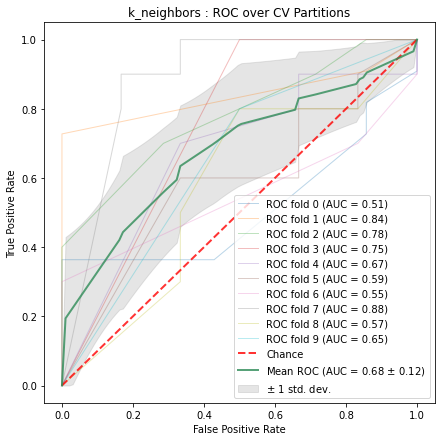

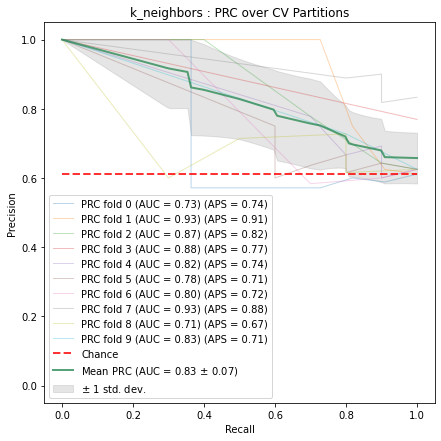

Avg. Model Balanced Accuracy = 0.6089393939393939 (std. dev. = 0.129485796749116)
Avg. Model Accuracy = 0.6494281045751634 (std. dev. = 0.12024825539606707)
Avg. Model F1-Score = 0.7322616999368917 (std. dev. = 0.09669355474200478)
Avg. Model Recall = 0.7845454545454544 (std. dev. = 0.13161740194923988)
Avg. Model Specificity = 0.4333333333333333 (std. dev. = 0.20968608434575237)
Avg. Model Precision = 0.6961438561438562 (std. dev. = 0.09309125179406794)
Avg. Model True Positives = 8.0 (std. dev. = 1.3416407864998738)
Avg. Model True Negatives = 2.7 (std. dev. = 1.268857754044952)
Avg. Model False Positives = 3.6 (std. dev. = 1.42828568570857)
Avg. Model False Negatives = 2.2 (std. dev. = 1.3266499161421599)
Avg. ROC AUC = 0.6795887445887446 (std. dev. = 0.12062975825584354)
Avg. PRC AUC = 0.8279025941378884 (std. dev. = 0.07112661390599193)
Avg. PRC Precision Score = 0.7659534876887818 (std. dev. = 0.07651455058429298)

---Feature Importances---



Names    Scores
10                          Diabetes  0.045758
40        Alkaline phosphatase (U/L)  0.044091
28                   Ascites degree*  0.040022
44    Major dimension of nodule (cm)  0.037857
21                  Liver Metastasis  0.032143
8                  Endemic Countries  0.026667
0                             Gender  0.026667
1                          Symptoms   0.025931
47             Oxygen Saturation (%)  0.025476
31                Haemoglobin (g/dL)  0.021212
14       Chronic Renal Insufficiency  0.020476
32           Mean Corpuscular Volume  0.017879
6         Hepatitis C Virus Antibody  0.017143
19               Portal Hypertension  0.015476
39  Gamma glutamyl transferase (U/L)  0.015000
35                   Albumin (mg/dL)  0.015000
5          Hepatitis B Core Antibody  0.013333
20            Portal Vein Thrombosis  0.011948
22             Radiological Hallmark  0.011667
33                   Leukocytes(G/L)  0.010476

K-Neighbors Run Time: 17.997514963150024


In [66]:
algorithm = 'k_neighbors'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('K-Neighbors Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

---
# Review result table (for global ROC and PRC figure building)

In [67]:
#Load pickle files of results
result_table = []

for algorithm in algorithmsToRun:
    tempDict = pickle.load(open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'rb'))
    result_table.append(tempDict)
    
result_table = pd.DataFrame.from_dict(result_table)

In [68]:
result_table
result_table.set_index('algorithm', inplace=True)

algorithm                                                fpr  \
0   logistic_regression  [0.0, 0.010101010101010102, 0.0202020202020202...   
1         decision_tree  [0.0, 0.010101010101010102, 0.0202020202020202...   
2         random_forest  [0.0, 0.010101010101010102, 0.0202020202020202...   
3           naive_bayes  [0.0, 0.010101010101010102, 0.0202020202020202...   
4                   XGB  [0.0, 0.010101010101010102, 0.0202020202020202...   
5                   LGB  [0.0, 0.010101010101010102, 0.0202020202020202...   
6                   SVM  [0.0, 0.010101010101010102, 0.0202020202020202...   
7                   ANN  [0.0, 0.010101010101010102, 0.0202020202020202...   
8              ExSTraCS  [0.0, 0.010101010101010102, 0.0202020202020202...   
9          ExSTraCS_QRF  [0.0, 0.010101010101010102, 0.0202020202020202...   
10                 eLCS  [0.0, 0.010101010101010102, 0.0202020202020202...   
11                  XCS  [0.0, 0.010101010101010102, 0.0202020202020202...   
12    gradient_boosting  [0.0, 0.010101010101010102, 0.0202020202020202...   
13          k_neighbors  [0.0, 0.010101010101010102, 0.0202020202020202...   

                                                  tpr       auc  \
0   [0.0, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, ...  0.735317   
1   [0.0, 0.15465840220385677, 0.17295316804407715...  0.678464   
2   [0.0, 0.509090909090909, 0.509090909090909, 0....  0.789633   
3   [0.0, 0.2536363636363636, 0.2536363636363636, ...  0.634910   
4   [0.0, 0.48882460973370073, 0.4894674012855832,...  0.760601   
5   [0.0, 0.41000000000000003, 0.41000000000000003...  0.745822   
6   [0.0, 0.3718181818181818, 0.3718181818181818, ...  0.750230   
7   [0.0, 0.42272727272727273, 0.42272727272727273...  0.718990   
8   [0.0, 0.27454545454545454, 0.27454545454545454...  0.658604   
9   [0.0, 0.26696969696969697, 0.2675757575757576,...  0.674350   
10  [0.0, 0.3727272727272727, 0.3727272727272727, ...  0.687989   
11  [0.0, 0.2602020202020202, 0.2604040404040404, ...  0.650507   
12  [0.0, 0.4581818181818182, 0.4581818181818182, ...  0.736235   
13  [0.0, 0.19418396082032446, 0.20927701254973985...  0.679158   

                                                 prec    pr_auc  ave_prec  
0   [0.9, 0.905050505050505, 0.9101010101010101, 0...  0.826283  0.840264  
1   [1.0, 0.9972883597883598, 0.9945767195767197, ...  0.825377  0.757169  
2   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  0.882153  0.888025  
3   [0.5, 0.5235690235690236, 0.5471380471380473, ...  0.729712  0.757834  
4   [0.9, 0.905050505050505, 0.9101010101010101, 0...  0.856209  0.864831  
5   [0.9, 0.905050505050505, 0.9101010101010101, 0...  0.834894  0.847351  
6   [0.9, 0.905050505050505, 0.9101010101010101, 0...  0.828654  0.842240  
7   [0.9, 0.905050505050505, 0.9101010101010101, 0...  0.824079  0.837221  
8   [0.8, 0.81010101010101, 0.8202020202020203, 0....  0.764078  0.784502  
9   [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...  0.779350  0.794546  
10  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  0.803465  0.817288  
11  [0.7, 0.7085858585858585, 0.7171717171717171, ...  0.751769  0.771619  
12  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  0.836333  0.846949  
13  [1.0, 0.9971939115878511, 0.9943878231757018, ...  0.827823  0.765953

---
# ROC Plot Summarizing Analysis

([<matplotlib.axis.XTick at 0x1e4b8302430>,
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 0, 'False Positive Rate')

([<matplotlib.axis.YTick at 0x1e4b5a3af10>,
 <a list of 11 Text major ticklabel objects>)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Comparing Algorithms: Testing Data with CV')

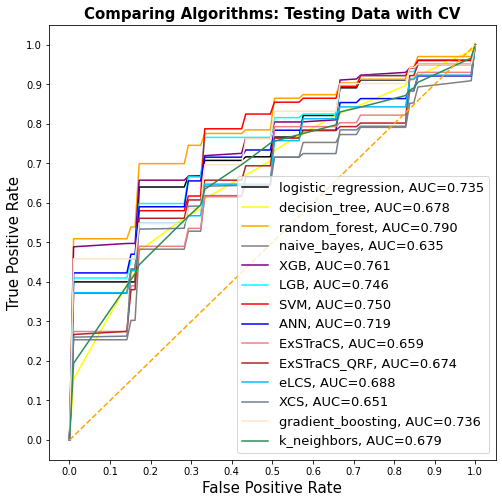

In [69]:
#Multi-algorithm ROC plot
fig = plt.figure(figsize=(8,8))
count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], color = algColors[count],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    count += 1
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_ROC_' + data_name), bbox_inches = "tight")
plt.show()


---
# PRC Plot Summarizing Analysis

([<matplotlib.axis.XTick at 0x1e4b968c910>,
 <a list of 11 Text major ticklabel objects>)

Text(0.5, 0, 'Recall')

([<matplotlib.axis.YTick at 0x1e4b96b9100>,
 <a list of 11 Text major ticklabel objects>)

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Comparing Algorithms: Testing Data with CV')

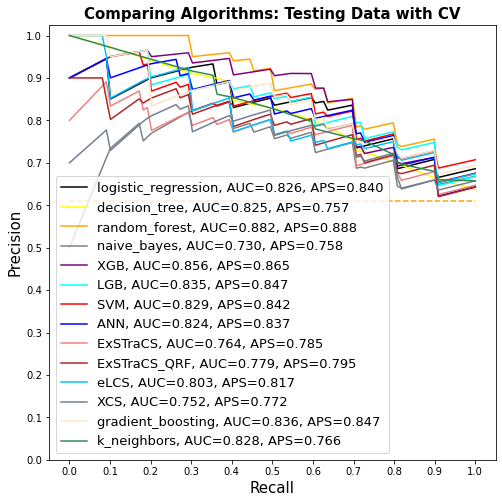

In [70]:
#Multi-algorithm PRC plot ['algorithm','fpr','tpr','auc','prec','pr_auc','ave_prec'])
#result_table.set_index('algorithm', inplace=True)

fig = plt.figure(figsize=(8,8))

count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['prec'], color = algColors[count],
             label="{}, AUC={:.3f}, APS={:.3f}".format(i, result_table.loc[i]['pr_auc'],result_table.loc[i]['ave_prec']))
    count += 1
noskill = len(yTestList[0][yTestList[0]==1]) / len(yTestList[0]) #Fraction of cases
plt.plot([0,1], [noskill,noskill], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_PRC_' + data_name), bbox_inches = "tight")
plt.show()


---
# Summarize Algorithm Metrics 

In [71]:
td = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_Metrics_'+data_name+'.csv')
metrics = list(td.columns.values.tolist()) 

metric_summary = pd.DataFrame(index=metrics,columns=algorithmsToRun)
master_list = []

for algorithm in algorithmsToRun:
    #Open file
    td = pd.read_csv(wd_path+output_folder+'/'+algorithm+'_Metrics_'+data_name+'.csv')
    master_list.append(td)
    for metric in metrics:
        ave = td[metric].mean()
        sd = td[metric].std()
        metric_summary.at[metric, algorithm] = str(round(ave,4))+' ('+str(round(sd,4))+')'
    
metric_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_Metrics_'+data_name+'.csv')   

In [72]:
metric_summary

logistic_regression    decision_tree    random_forest  \
Balanced Accuracy     0.6565 (0.1185)  0.6482 (0.1027)  0.7187 (0.0793)   
Accuracy              0.6689 (0.1102)  0.6602 (0.0658)  0.7209 (0.0718)   
F1_Score              0.7248 (0.0976)  0.7165 (0.0436)  0.7624 (0.0608)   
Recall                0.7082 (0.1002)  0.6964 (0.1078)  0.7255 (0.0757)   
Specificity           0.6048 (0.1673)     0.6 (0.2823)   0.7119 (0.133)   
Precision             0.7453 (0.1047)  0.7675 (0.1232)  0.8082 (0.0734)   
TP                       7.2 (0.9189)     7.1 (1.1005)     7.4 (0.8433)   
TN                       3.8 (1.0328)     3.8 (1.8135)     4.5 (0.9718)   
FP                       2.5 (1.0801)     2.5 (1.7159)     1.8 (0.7888)   
FN                       3.0 (1.1547)     3.1 (1.1005)     2.8 (0.7888)   
ROC_AUC                0.7365 (0.125)    0.679 (0.103)  0.7918 (0.0787)   
PRC_AUC               0.8266 (0.1004)  0.8254 (0.0465)   0.882 (0.0447)   
PRC_APS                0.8403 (0.088)  0.7572 (0.0764)   0.888 (0.0421)   

                       naive_bayes              XGB              LGB  \
Balanced Accuracy  0.6401 (0.1346)  0.6689 (0.0891)  0.6589 (0.1058)   
Accuracy           0.6679 (0.1147)  0.6775 (0.0764)  0.6727 (0.0972)   
F1_Score           0.7378 (0.0846)  0.7301 (0.0593)  0.7283 (0.0855)   
Recall             0.7564 (0.1121)  0.7045 (0.0703)  0.7155 (0.1101)   
Specificity        0.5238 (0.2535)   0.6333 (0.158)  0.6024 (0.1778)   
Precision          0.7317 (0.1078)   0.7632 (0.079)  0.7493 (0.0883)   
TP                    7.7 (1.0593)     7.2 (0.9189)     7.3 (1.1595)   
TN                     3.3 (1.567)     4.0 (1.0541)     3.8 (1.1353)   
FP                    3.0 (1.5635)     2.3 (0.9487)     2.5 (1.0801)   
FN                    2.5 (1.1785)     3.0 (0.6667)     2.9 (1.1005)   
ROC_AUC             0.6353 (0.172)  0.7621 (0.0999)   0.747 (0.1139)   
PRC_AUC            0.7299 (0.1547)   0.856 (0.0934)  0.8351 (0.1045)   
PRC_APS            0.7578 (0.1332)  0.8648 (0.0789)  0.8474 (0.0903)   

                               SVM              ANN         ExSTraCS  \
Balanced Accuracy  0.6785 (0.0716)  0.6782 (0.1043)  0.6253 (0.1157)   
Accuracy           0.6602 (0.0743)  0.6973 (0.0951)   0.655 (0.1065)   
F1_Score           0.6796 (0.0862)  0.7547 (0.0793)  0.7227 (0.1094)   
Recall             0.6045 (0.1608)  0.7564 (0.0978)  0.7482 (0.1542)   
Specificity        0.7524 (0.1845)     0.6 (0.1656)   0.5024 (0.235)   
Precision           0.819 (0.1138)  0.7581 (0.0824)  0.7177 (0.1021)   
TP                    6.2 (1.8738)     7.7 (0.9487)     7.6 (1.5055)   
TN                    4.7 (1.0593)     3.8 (1.1353)     3.2 (1.6193)   
FP                    1.6 (1.2649)     2.5 (0.9718)     3.1 (1.4491)   
FN                     4.0 (1.633)     2.5 (1.0801)     2.6 (1.7127)   
ROC_AUC            0.7511 (0.1233)  0.7202 (0.1244)  0.6596 (0.1277)   
PRC_AUC             0.829 (0.0983)  0.8243 (0.1024)  0.7648 (0.1191)   
PRC_APS            0.8422 (0.0871)  0.8372 (0.0899)  0.7845 (0.1032)   

                      ExSTraCS_QRF             eLCS              XCS  \
Balanced Accuracy   0.5639 (0.067)  0.6211 (0.1569)   0.6151 (0.133)   
Accuracy           0.6259 (0.0679)  0.6674 (0.1399)  0.6417 (0.1156)   
F1_Score           0.7281 (0.0658)  0.7515 (0.1073)  0.7159 (0.0827)   
Recall             0.8255 (0.1292)  0.8136 (0.1286)  0.7255 (0.0892)   
Specificity        0.3024 (0.1695)  0.4286 (0.2582)  0.5048 (0.2153)   
Precision          0.6597 (0.0497)  0.7047 (0.1121)  0.7109 (0.0958)   
TP                    8.4 (1.2649)     8.3 (1.3375)     7.4 (0.9661)   
TN                    1.9 (1.1005)     2.7 (1.6364)     3.2 (1.3984)   
FP                    4.4 (1.1738)     3.6 (1.6465)     3.1 (1.2867)   
FN                    1.8 (1.3984)     1.9 (1.2867)     2.8 (0.9189)   
ROC_AUC            0.6755 (0.1208)  0.6891 (0.1502)   0.6514 (0.175)   
PRC_AUC            0.7799 (0.0955)  0.8045 (0.0931)   0.752 (0.1357)   
PRC_APS      

---
# Performance Metric Boxplots Comparing Algorithms

Text(0.5, 1.0, 'Comparing Algorithm Balanced Accuracy')

Text(0, 0.5, 'Balanced Accuracy')

Text(0.5, 0, 'ML Algorithm')

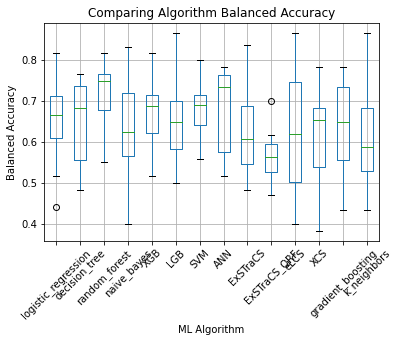

Text(0.5, 1.0, 'Comparing Algorithm Accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'ML Algorithm')

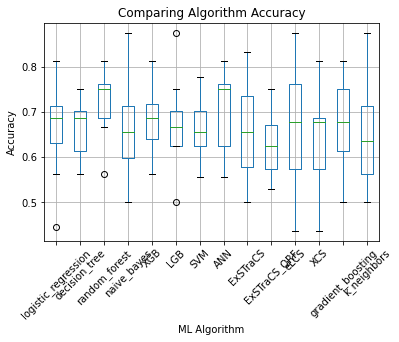

Text(0.5, 1.0, 'Comparing Algorithm F1_Score')

Text(0, 0.5, 'F1_Score')

Text(0.5, 0, 'ML Algorithm')

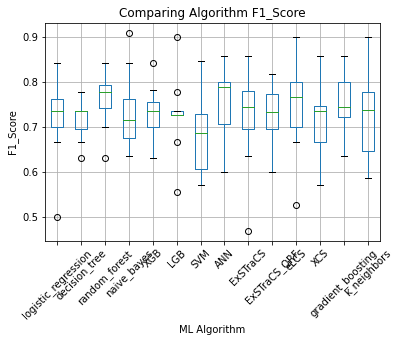

Text(0.5, 1.0, 'Comparing Algorithm Recall')

Text(0, 0.5, 'Recall')

Text(0.5, 0, 'ML Algorithm')

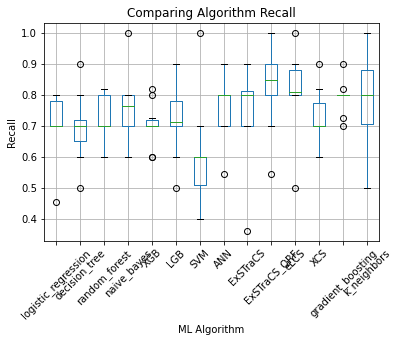

Text(0.5, 1.0, 'Comparing Algorithm Specificity')

Text(0, 0.5, 'Specificity')

Text(0.5, 0, 'ML Algorithm')

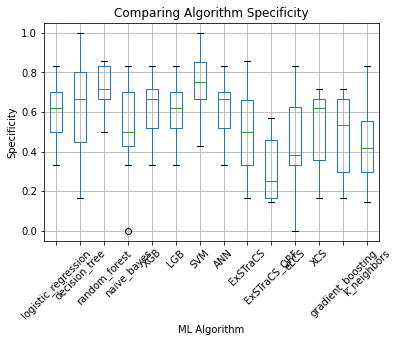

Text(0.5, 1.0, 'Comparing Algorithm Precision')

Text(0, 0.5, 'Precision')

Text(0.5, 0, 'ML Algorithm')

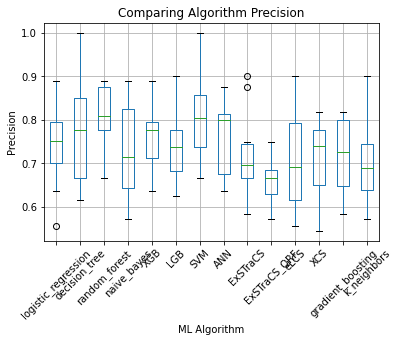

Text(0.5, 1.0, 'Comparing Algorithm TP')

Text(0, 0.5, 'TP')

Text(0.5, 0, 'ML Algorithm')

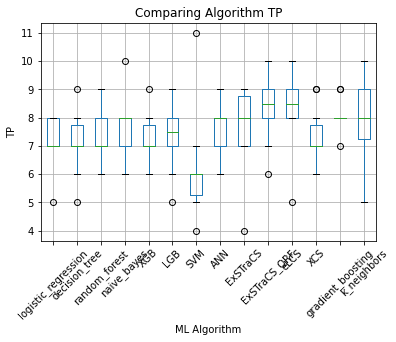

Text(0.5, 1.0, 'Comparing Algorithm TN')

Text(0, 0.5, 'TN')

Text(0.5, 0, 'ML Algorithm')

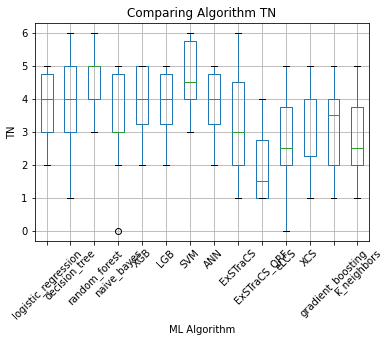

Text(0.5, 1.0, 'Comparing Algorithm FP')

Text(0, 0.5, 'FP')

Text(0.5, 0, 'ML Algorithm')

Text(0.5, 1.0, 'Comparing Algorithm FN')

Text(0, 0.5, 'FN')

Text(0.5, 0, 'ML Algorithm')

Text(0.5, 1.0, 'Comparing Algorithm ROC_AUC')

Text(0, 0.5, 'ROC_AUC')

Text(0.5, 0, 'ML Algorithm')

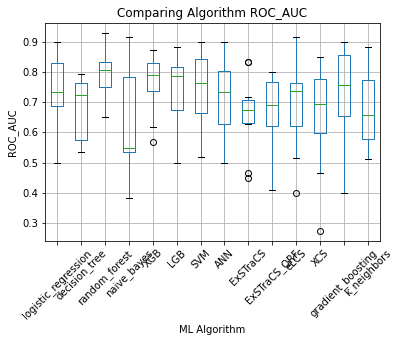

Text(0.5, 1.0, 'Comparing Algorithm PRC_AUC')

Text(0, 0.5, 'PRC_AUC')

Text(0.5, 0, 'ML Algorithm')

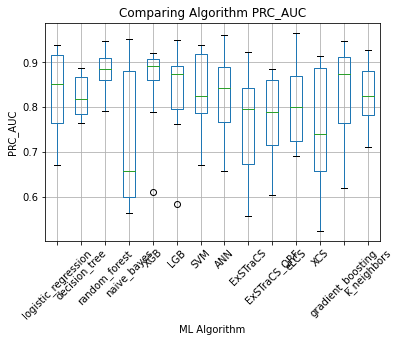

Text(0.5, 1.0, 'Comparing Algorithm PRC_APS')

Text(0, 0.5, 'PRC_APS')

Text(0.5, 0, 'ML Algorithm')

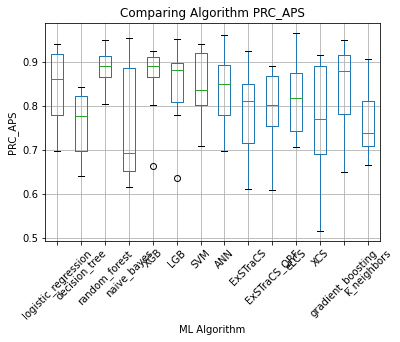

In [73]:

#For each metric
for metric in metrics:
    i = 0
    tempList = []
    for algorithm in algorithmsToRun:
        temp_td = master_list[i]
        tempList.append(temp_td[metric].tolist())
        i += 1
        
    td = pd.DataFrame(tempList)
    td = td.transpose()
    td.columns = algorithmsToRun
        
    boxplot = td.boxplot(column=algorithmsToRun,rot=45)
    plt.title('Comparing Algorithm '+ str(metric))
    plt.ylabel(str(metric))
    plt.xlabel('ML Algorithm')
    plt.savefig((wd_path+output_folder+'/'+'Compare_'+str(metric)+'_Boxplot_'+data_name), bbox_inches = "tight")
    plt.show()


---
# Statistical Comparisons
- Kruskal Wallis AOV comparing ML algorithms
- Mann-Whitney U test - Pairwise algorithm differences  

## Kruskal Wallis Test - Algorithm comparisons for each metric
- Are any algorithms performing statistically better or worse? 

## Mann-Whiney Test - Pairwise Post-Hoc Analysis 
- For any metric where kruskal wallis test was significant.

In [74]:
if len(algorithmsToRun) > 1:
    label = ['statistic','pvalue','sig']
    kruskal_summary = pd.DataFrame(index=metrics,columns=label)
    for metric in metrics:
        tempArray = []
        for i in range(len(algorithmsToRun)):
            tempArray.append(master_list[i][metric])
        try:
            result = stats.kruskal(*tempArray)
        except:
            result = [tempArray[0],1]
        #result = stats.kruskal(master_list[0][metric],master_list[1][metric],master_list[2][metric],master_list[3][metric],master_list[4][metric],master_list[5][metric],master_list[6][metric]) 
        kruskal_summary.at[metric, 'statistic'] = str(round(result[0],6))
        kruskal_summary.at[metric, 'pvalue'] = str(round(result[1],6))
        if result[1] < sig_cutoff:
            kruskal_summary.at[metric, 'sig'] = str('*')
        else:
            kruskal_summary.at[metric, 'sig'] = str('')

    kruskal_summary

    kruskal_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_KruskalWallis_'+data_name+'.csv')   

statistic    pvalue sig
Balanced Accuracy  14.896912  0.313832    
Accuracy            8.894129  0.780892    
F1_Score           10.128555   0.68339    
Recall             33.213291  0.001583   *
Specificity        34.102197  0.001161   *
Precision          22.867153  0.043298   *
TP                  31.80121  0.002571   *
TN                 33.135192  0.001626   *
FP                 33.637943  0.001366   *
FN                 33.169984  0.001607   *
ROC_AUC            16.381459  0.229143    
PRC_AUC            16.860573  0.205757    
PRC_APS            24.956212  0.023391   *

In [75]:
if len(algorithmsToRun) > 1:
    algCount = len(algorithmsToRun)
    for metric in metrics:
        if kruskal_summary['sig'][metric] == '*':
            mann_stats = []
            #Balanced Accuracy
            for i in range(0,algCount-1):
                for j in range(i+1,algCount):
                    set1 = master_list[i][metric]
                    set2 = master_list[j][metric]

                    #print('Mann-WhitneyU: '+str(algorithmsToRun[i])+' vs. '+str(algorithmsToRun[j]))
                    try:
                        report = stats.mannwhitneyu(set1,set2)
                    except:
                        report = [set1[0],1]
                    #report
                    tempstats = [algorithmsToRun[i], algorithmsToRun[j], report[0], report[1], '']
                    if report[1] < sig_cutoff:
                        tempstats[4] = '*'
                    mann_stats.append(tempstats)

            mann_stats_df = pd.DataFrame(mann_stats)
            mann_stats_df.columns = ['Algorithm 1', 'Algorithm 2', 'statistic', 'p-value', 'sig']
            filepath = wd_path+output_folder+'/'+'MannWhitney_'+str(metric)+'_'+data_name+'.csv'
            mann_stats_df.to_csv(filepath, index = False) 
            mann_stats_df

Algorithm 1        Algorithm 2  statistic   p-value sig
0   logistic_regression      decision_tree       42.0  0.275215    
1   logistic_regression      random_forest       48.5  0.467950    
2   logistic_regression        naive_bayes       40.5  0.238474    
3   logistic_regression                XGB       44.5  0.342393    
4   logistic_regression                LGB       47.5  0.437337    
..                  ...                ...        ...       ...  ..
86                 eLCS  gradient_boosting       34.0  0.104515    
87                 eLCS        k_neighbors       41.0  0.256079    
88                  XCS  gradient_boosting       25.5  0.029973   *
89                  XCS        k_neighbors       31.5  0.081479    
90    gradient_boosting        k_neighbors       50.0  0.484363    

[91 rows x 5 columns]

Algorithm 1        Algorithm 2  statistic   p-value sig
0   logistic_regression      decision_tree       47.0  0.424462    
1   logistic_regression      random_forest       30.0  0.066928    
2   logistic_regression        naive_bayes       41.0  0.257875    
3   logistic_regression                XGB       44.0  0.336693    
4   logistic_regression                LGB       49.5  0.500000    
..                  ...                ...        ...       ...  ..
86                 eLCS  gradient_boosting       46.0  0.394776    
87                 eLCS        k_neighbors       49.5  0.500000    
88                  XCS  gradient_boosting       45.5  0.378077    
89                  XCS        k_neighbors       37.5  0.179435    
90    gradient_boosting        k_neighbors       42.5  0.296674    

[91 rows x 5 columns]

Algorithm 1        Algorithm 2  statistic   p-value sig
0   logistic_regression      decision_tree       49.0  0.484787    
1   logistic_regression      random_forest       33.0  0.104332    
2   logistic_regression        naive_bayes       46.0  0.395089    
3   logistic_regression                XGB       46.0  0.394500    
4   logistic_regression                LGB       49.0  0.484828    
..                  ...                ...        ...       ...  ..
86                 eLCS  gradient_boosting       43.5  0.323645    
87                 eLCS        k_neighbors       47.0  0.424886    
88                  XCS  gradient_boosting       45.5  0.380441    
89                  XCS        k_neighbors       41.0  0.259790    
90    gradient_boosting        k_neighbors       39.5  0.223904    

[91 rows x 5 columns]

Algorithm 1        Algorithm 2  statistic   p-value sig
0   logistic_regression      decision_tree       45.0  0.355986    
1   logistic_regression      random_forest       47.5  0.434249    
2   logistic_regression        naive_bayes       38.5  0.183074    
3   logistic_regression                XGB       45.5  0.371386    
4   logistic_regression                LGB       46.0  0.388520    
..                  ...                ...        ...       ...  ..
86                 eLCS  gradient_boosting       36.0  0.128166    
87                 eLCS        k_neighbors       42.0  0.276533    
88                  XCS  gradient_boosting       25.5  0.027046   *
89                  XCS        k_neighbors       32.5  0.089479    
90    gradient_boosting        k_neighbors       48.5  0.467477    

[91 rows x 5 columns]

Algorithm 1        Algorithm 2  statistic   p-value sig
0   logistic_regression      decision_tree       47.0  0.423265    
1   logistic_regression      random_forest       31.5  0.076515    
2   logistic_regression        naive_bayes       41.5  0.264557    
3   logistic_regression                XGB       44.0  0.331979    
4   logistic_regression                LGB       49.0  0.484293    
..                  ...                ...        ...       ...  ..
86                 eLCS  gradient_boosting       45.0  0.364288    
87                 eLCS        k_neighbors       49.5  0.500000    
88                  XCS  gradient_boosting       46.0  0.390032    
89                  XCS        k_neighbors       39.0  0.206377    
90    gradient_boosting        k_neighbors       43.5  0.320613    

[91 rows x 5 columns]

Algorithm 1        Algorithm 2  statistic   p-value sig
0   logistic_regression      decision_tree       48.0  0.453812    
1   logistic_regression      random_forest       31.0  0.071959    
2   logistic_regression        naive_bayes       41.0  0.254580    
3   logistic_regression                XGB       44.5  0.346853    
4   logistic_regression                LGB       50.0  0.484388    
..                  ...                ...        ...       ...  ..
86                 eLCS  gradient_boosting       45.0  0.363672    
87                 eLCS        k_neighbors       50.0  0.484603    
88                  XCS  gradient_boosting       45.0  0.359111    
89                  XCS        k_neighbors       39.0  0.207862    
90    gradient_boosting        k_neighbors       43.0  0.307264    

[91 rows x 5 columns]

Algorithm 1        Algorithm 2  statistic   p-value sig
0   logistic_regression      decision_tree       41.5  0.252939    
1   logistic_regression      random_forest       48.0  0.450566    
2   logistic_regression        naive_bayes       42.0  0.271292    
3   logistic_regression                XGB       43.0  0.287654    
4   logistic_regression                LGB       49.0  0.483349    
..                  ...                ...        ...       ...  ..
86                 eLCS  gradient_boosting       38.0  0.153228    
87                 eLCS        k_neighbors       41.0  0.248839    
88                  XCS  gradient_boosting       25.5  0.025626   *
89                  XCS        k_neighbors       33.5  0.103417    
90    gradient_boosting        k_neighbors       48.5  0.467477    

[91 rows x 5 columns]

Algorithm 1        Algorithm 2  statistic   p-value sig
0   logistic_regression      decision_tree       23.0  0.022577   *
1   logistic_regression      random_forest       37.0  0.172352    
2   logistic_regression        naive_bayes       31.0  0.080986    
3   logistic_regression                XGB       44.0  0.338792    
4   logistic_regression                LGB       45.0  0.366865    
..                  ...                ...        ...       ...  ..
86                 eLCS  gradient_boosting       36.0  0.153745    
87                 eLCS        k_neighbors       33.0  0.106147    
88                  XCS  gradient_boosting       32.0  0.092938    
89                  XCS        k_neighbors       42.0  0.285375    
90    gradient_boosting        k_neighbors       24.0  0.026951   *

[91 rows x 5 columns]

---
# Visualize Feature Importance Results Across Algorithms

## Specify dataset specific paths/names

In [76]:
figx = 24
figy = 12
    
#Feature names to use in the final publication figures
df = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_FI_'+data_name+'.csv')

printfeatureNames = list(df.columns)
print(printfeatureNames)

['Gender', 'Symptoms ', 'Alcohol', 'Hepatitis B Surface Antigen', 'Hepatitis B e Antigen', 'Hepatitis B Core Antibody', 'Hepatitis C Virus Antibody', 'Cirrhosis', 'Endemic Countries', 'Smoking', 'Diabetes', 'Obesity', 'Hemochromatosis', 'Arterial Hypertension', 'Chronic Renal Insufficiency', 'Human Immunodeficiency Virus', 'Nonalcoholic Steatohepatitis', 'Esophageal Varices', 'Splenomegaly', 'Portal Hypertension', 'Portal Vein Thrombosis', 'Liver Metastasis', 'Radiological Hallmark', 'Age at diagnosis', 'Grams of Alcohol per day', 'Packs of cigarets per year', 'Performance Status*', 'Encephalopathy degree*', 'Ascites degree*', 'International Normalised Ratio*', 'Alpha-Fetoprotein (ng/mL)', 'Haemoglobin (g/dL)', 'Mean Corpuscular Volume', 'Leukocytes(G/L)', 'Platelets', 'Albumin (mg/dL)', 'Total Bilirubin(mg/dL)', 'Alanine transaminase (U/L)', 'Aspartate transaminase (U/L)', 'Gamma glutamyl transferase (U/L)', 'Alkaline phosphatase (U/L)', 'Total Proteins (g/dL)', 'Creatinine (mg/dL)', 

## Load feature importance and balanced accuracy results
- Do this generically so that future algorithms can be added here
- Identify a feature list for each algorithm (only features with average scores over zero)
- Identify union of these feature lists - master feature list to be included in bar chart
- Have a max_features to visualize - use ranking to reduce above list as needed to top n features only.
- Add ability to load LCS or other external algorithm to these results

In [77]:
#algorithm feature importance dataframe list (used to generate FI boxplots for each algorithm)
fi_df_list = []
#algorithm feature importance averages list (used to generate composite FI barplots)
fi_ave_list = []
#algorithm focus metric averages list (used in weighted FI viz)
ave_metric_list = []
#list of pre-feature selection features as they appear in FI reports for each algorithm
all_feature_list = []

In [78]:
for each in algorithmsToRun:
    #Get relevant feature importance info
    temp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_FI_'+data_name+'.csv')
    if each == algorithmsToRun[0]: #Should be same for all algorithm files (i.e. all original features in standard CV dataset order)
        all_feature_list = temp_df.columns.tolist()
    fi_df_list.append(temp_df) 
    fi_ave_list.append(temp_df.mean().tolist())
    
    #Get relevant metric info
    tmp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_Metrics_'+data_name+'.csv')
    ave_metric_list.append(tmp_df[focus_metric].mean())
ave_metric_list

[0.6564718614718614,
 0.6481818181818182,
 0.7186796536796537,
 0.64008658008658,
 0.668939393939394,
 0.6589177489177489,
 0.6784632034632034,
 0.6781818181818182,
 0.6252813852813853,
 0.5639177489177489,
 0.621103896103896,
 0.6151082251082252,
 0.6341774891774892,
 0.6089393939393939]

### Normalize average scores (Range 0-1)

In [79]:
#Normalize average scores so all values range between 0 and 1 (important for combining FI's)
fi_ave_norm_list = []
for each in fi_ave_list: #each algorithm   
    normList = []
    for i in range(len(each)):
        if each[i] <= 0:
            normList.append(0)
        else:
            normList.append((each[i])/(max(each)))
    fi_ave_norm_list.append(normList)


### Identify features with non-zero averages

In [80]:
# For each algorithm identify all non-zero features
alg_non_zero_FI_list = []
for each in fi_ave_list: #each algorithm
    
    temp_non_zero_list = []
    for i in range(len(each)): #each feature
        if each[i] > 0.0:
            temp_non_zero_list.append(all_feature_list[i])
    
    alg_non_zero_FI_list.append(temp_non_zero_list)

### Identify union of features with non-zero averages over all algorithms

In [81]:
#Identify a union list over all algorithms of features with non-zero FI (These are candidates for vizualization)
non_zero_union_features = alg_non_zero_FI_list[0] #grab first algorithm's list

for j in range(1,len(algorithmsToRun)):
    #print(j)
    non_zero_union_features = list(set(non_zero_union_features) | set(alg_non_zero_FI_list[j]))

#print(non_zero_union_features)

non_zero_union_indexes = []
for i in non_zero_union_features:
    non_zero_union_indexes.append(all_feature_list.index(i))
non_zero_union_indexes

[36,
 45,
 25,
 18,
 41,
 44,
 2,
 43,
 12,
 9,
 21,
 27,
 31,
 26,
 11,
 6,
 17,
 24,
 1,
 40,
 30,
 38,
 5,
 37,
 20,
 19,
 23,
 39,
 32,
 48,
 0,
 8,
 34,
 47,
 46,
 22,
 29,
 10,
 3,
 35,
 42,
 28,
 14,
 33,
 7,
 16]

### Identify list of top features over all algorithms to visualize

In [82]:
#If remaining non-zero feature list is still larger than we want to visualize, pick only top features for visualization
featuresToViz = None
if len(non_zero_union_features) > topResults:
    #Identify a top set of feature values
    scoreSumDict = {}
    i = 0
    for each in non_zero_union_features: #for each non-zero feature
        for j in range(len(algorithmsToRun)): #for each algorithm
            #grab target score from each algorithm
            score = fi_ave_norm_list[j][non_zero_union_indexes[i]]
            #multiply score by algorithm performance weight
            score = score*ave_metric_list[j]
            if not each in scoreSumDict:
                scoreSumDict[each] = score
            else:
                scoreSumDict[each] += score
        i += 1
        
    for each in scoreSumDict:
        scoreSumDict[each] = scoreSumDict[each]/ len(algorithmsToRun)
    #print(scoreSumDict)

    #Rank and select top features to visualize

    #Sort features by decreasing score
    scoreSumDict_features = sorted(scoreSumDict, key=lambda x: scoreSumDict[x], reverse=True)
    #scoreSumDict_features

    featuresToViz = scoreSumDict_features[0:topResults]
    #featuresToViz
else:
    featuresToViz = non_zero_union_features #Ranked feature name order

## Generate individual feature importance boxplots for each algorithm

Text(0.5, 1.0, 'logistic_regression')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4e2901760>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

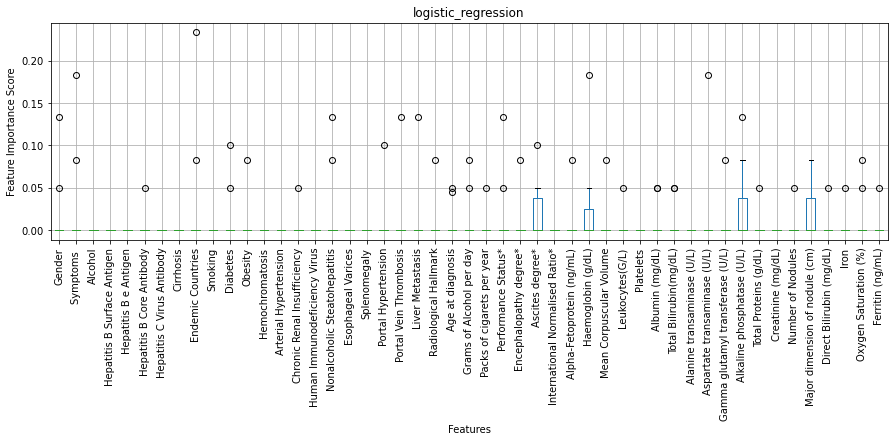

Text(0.5, 1.0, 'decision_tree')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4b7d7d460>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

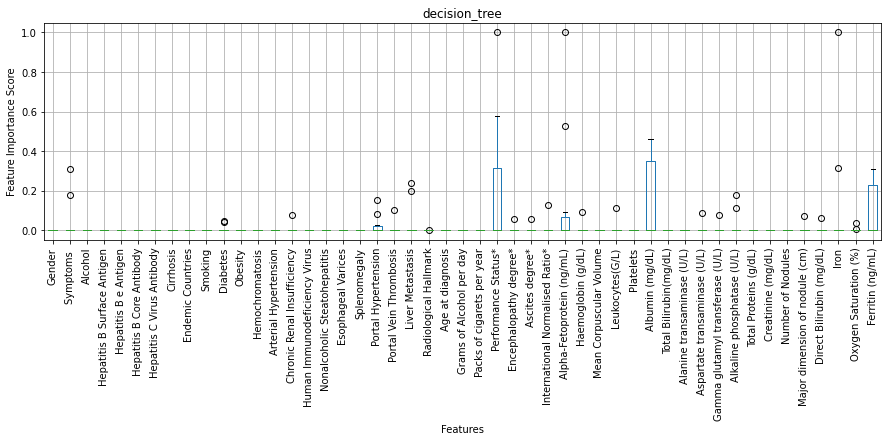

Text(0.5, 1.0, 'random_forest')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4de05e700>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

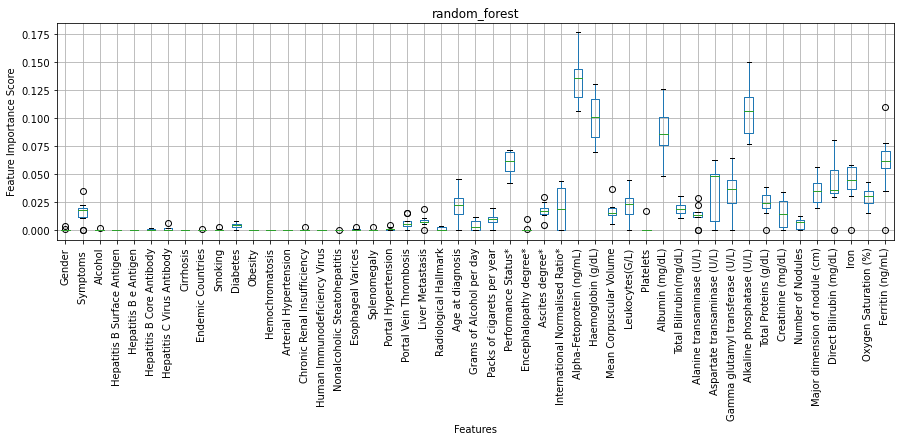

Text(0.5, 1.0, 'naive_bayes')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4dc02c280>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

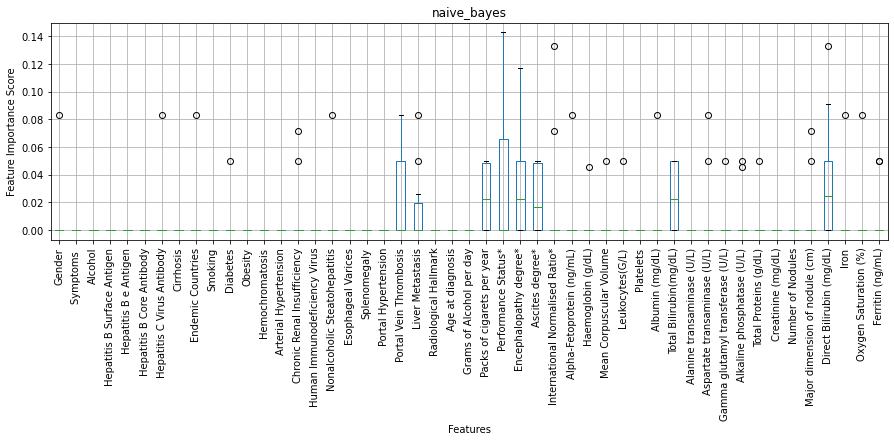

Text(0.5, 1.0, 'XGB')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4b831e1f0>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

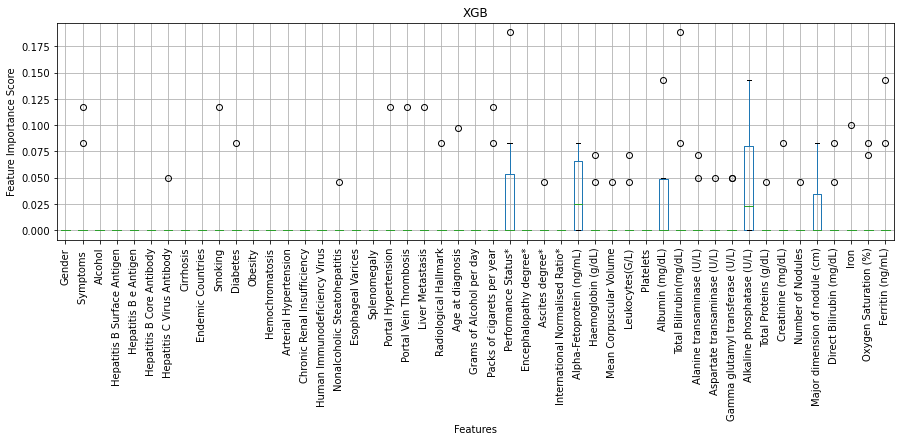

Text(0.5, 1.0, 'LGB')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4e2ce1a90>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

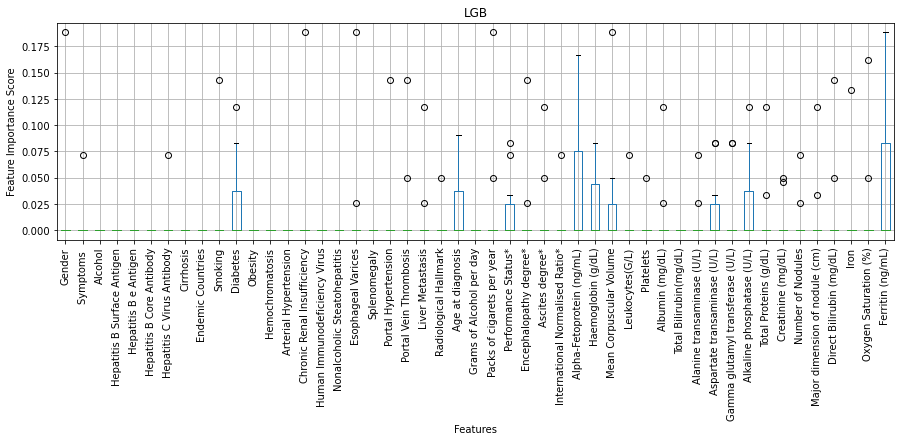

Text(0.5, 1.0, 'SVM')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4e2903b20>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

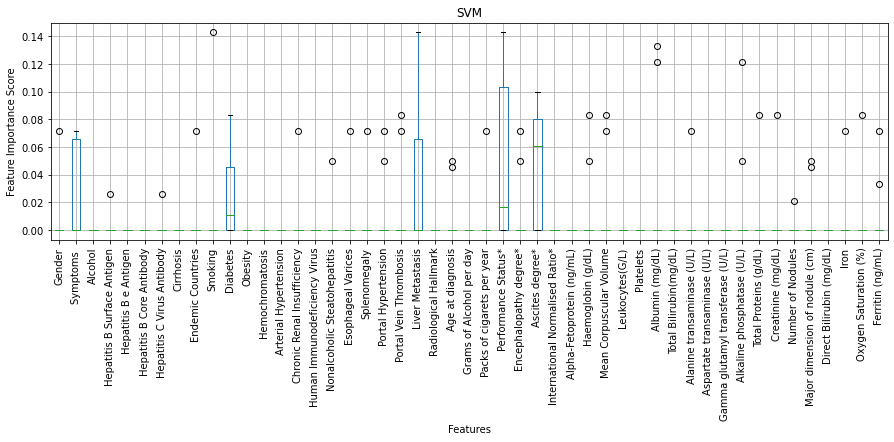

Text(0.5, 1.0, 'ANN')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4b8387880>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

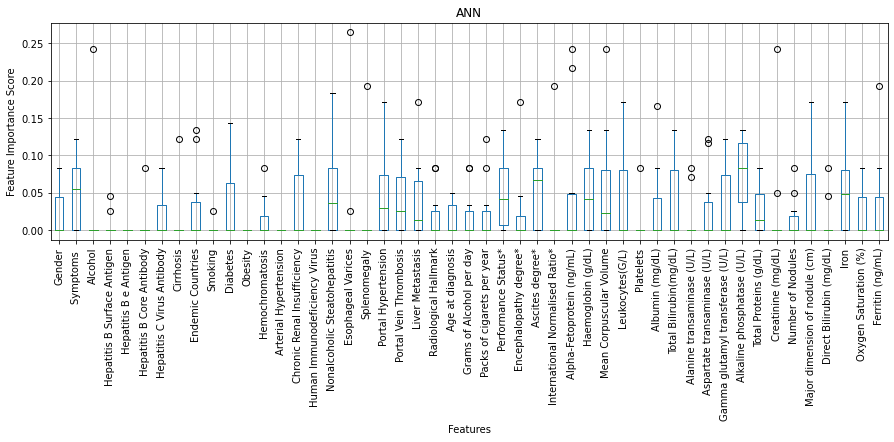

Text(0.5, 1.0, 'ExSTraCS')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4e2f5b550>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

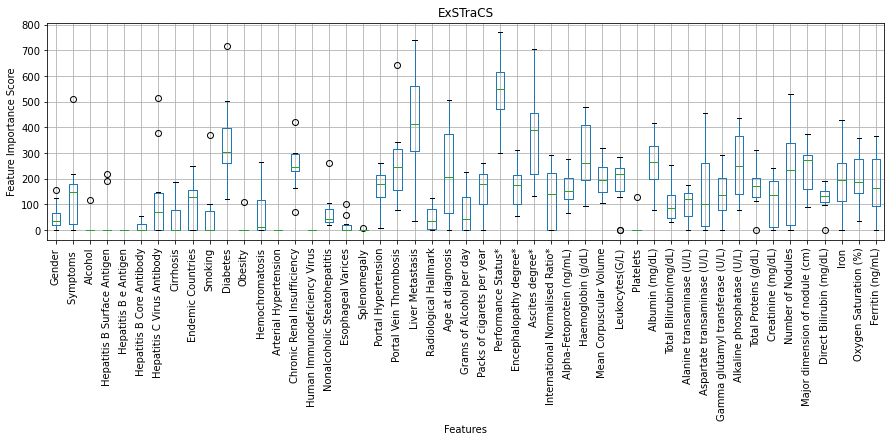

Text(0.5, 1.0, 'ExSTraCS_QRF')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4b64d2370>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

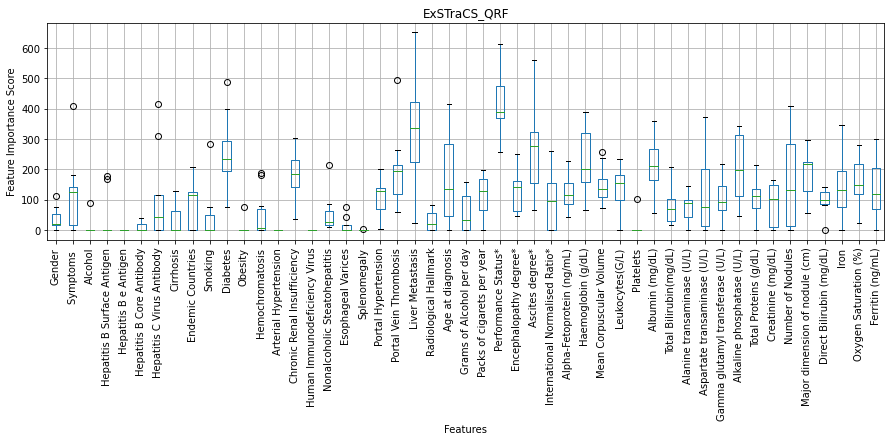

Text(0.5, 1.0, 'eLCS')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4dcd5fb50>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

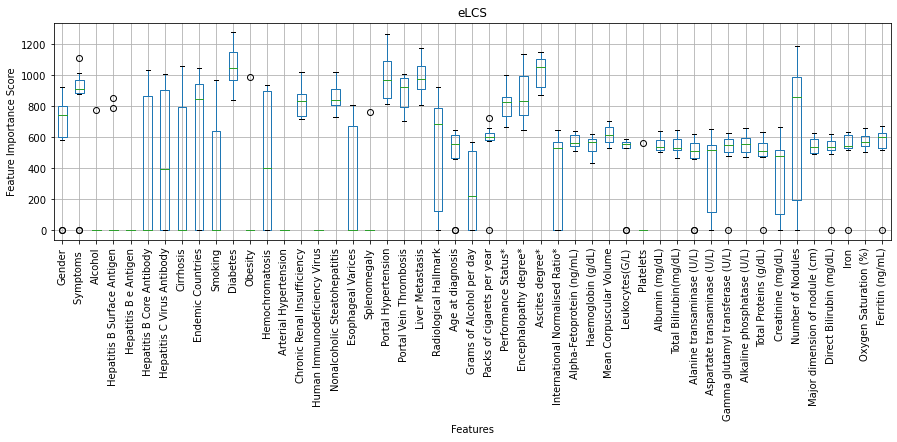

Text(0.5, 1.0, 'XCS')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4db7a7970>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

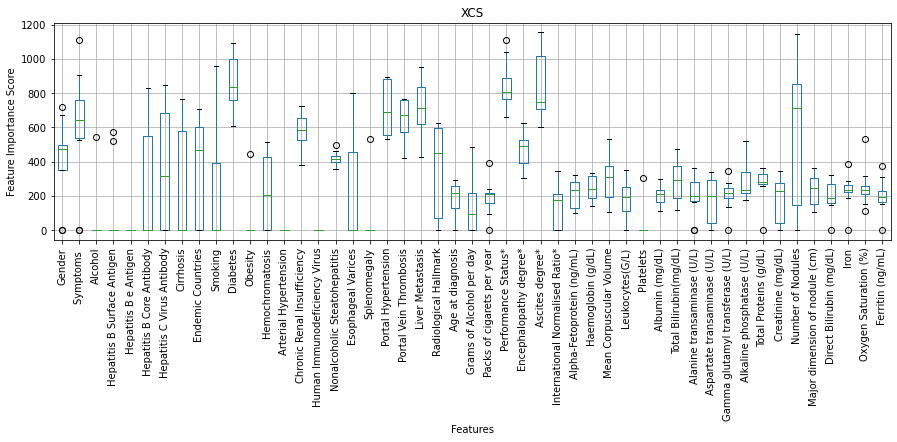

Text(0.5, 1.0, 'gradient_boosting')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4dd833b20>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

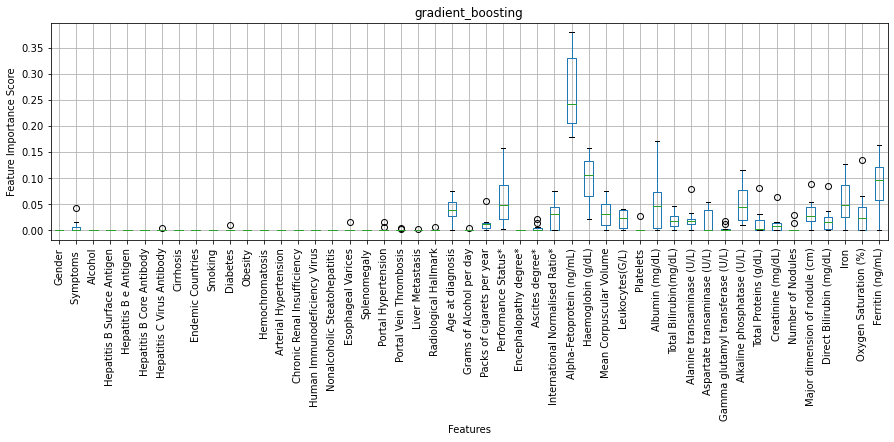

Text(0.5, 1.0, 'k_neighbors')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1e4ded2a0d0>,
 [Text(0, 0, 'Gender'),
  Text(0, 0, 'Symptoms '),
  Text(0, 0, 'Alcohol'),
  Text(0, 0, 'Hepatitis B Surface Antigen'),
  Text(0, 0, 'Hepatitis B e Antigen'),
  Text(0, 0, 'Hepatitis B Core Antibody'),
  Text(0, 0, 'Hepatitis C Virus Antibody'),
  Text(0, 0, 'Cirrhosis'),
  Text(0, 0, 'Endemic Countries'),
  Text(0, 0, 'Smoking'),
  Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Obesity'),
  Text(0, 0, 'Hemochromatosis'),
  Text(0, 0, 'Arterial Hypertension'),
  Text(0, 0, 'Chronic Renal Insufficiency'),
  Text(0, 0, 'Human Immunodeficiency Virus'),
  Text(0, 0, 'Nonalcoholic Steatohepatitis'),
  Text(0, 0, 'Esophageal Varices'),
  Text(0, 0, 'Splenomegaly'),
  Text(0, 0, 'Portal Hypertension'),
  Text(0, 0, 'Portal Vein Thrombosis'),
  Text(0, 0, 'Liver Metastasis'),
  Text(0, 0, 'Radiological Hallmark'),
  Text(0, 0, 'Age at diagnosis'),
  Text(0, 0, 'Grams of Alcohol per day'),
  Text(0, 0, 'Packs of cigarets per year'),
  Text(0, 0, 'Performance 

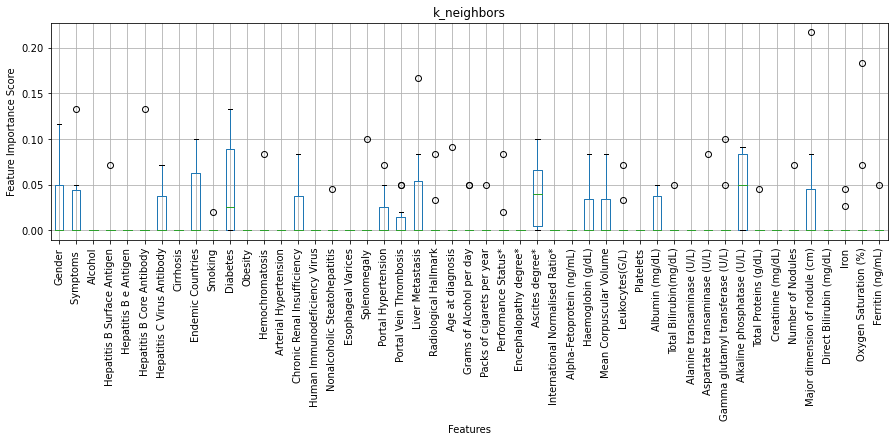

In [83]:
counter = 0
for df in fi_df_list:
    fig = plt.figure(figsize=(15,4))
    boxplot = df.boxplot(rot=90)
    plt.title(algorithmsToRun[counter])
    plt.ylabel('Feature Importance Score')
    plt.xlabel('Features')
    plt.xticks(np.arange(1,len(printfeatureNames)+1), printfeatureNames,rotation='vertical')
    plt.savefig((wd_path+output_folder+'/'+algorithmsToRun[counter]+'_boxplot_' + data_name), bbox_inches = "tight")
    plt.show()

    counter += 1

### Create Normalized dataframes with feature viz subsets

In [84]:
featuresToViz

feature_indexToViz = []
for i in featuresToViz:
    feature_indexToViz.append(all_feature_list.index(i))
feature_indexToViz

#Preserve features in original dataset order for consistency
top_fi_ave_norm_list = []
for i in range(len(algorithmsToRun)):
    tempList = []
    for j in range(len(fi_ave_norm_list[i])):
        if j in feature_indexToViz:
            tempList.append(fi_ave_norm_list[i][j])
    top_fi_ave_norm_list.append(tempList)

#Create feature name list in propper order
all_feature_listToViz = []
for j in (all_feature_list):
    if j in featuresToViz:
        all_feature_listToViz.append(j)
all_feature_listToViz

['Performance Status*',
 'Alkaline phosphatase (U/L)',
 'Ascites degree*',
 'Alpha-Fetoprotein (ng/mL)',
 'Liver Metastasis',
 'Diabetes',
 'Haemoglobin (g/dL)',
 'Albumin (mg/dL)',
 'Symptoms ',
 'Ferritin (ng/mL)',
 'Portal Vein Thrombosis',
 'Major dimension of nodule (cm)',
 'Portal Hypertension',
 'Iron',
 'Mean Corpuscular Volume',
 'Oxygen Saturation (%)',
 'Chronic Renal Insufficiency',
 'Encephalopathy degree*',
 'Packs of cigarets per year',
 'Total Bilirubin(mg/dL)']

[26, 40, 28, 30, 21, 10, 31, 35, 1, 48, 20, 44, 19, 46, 32, 47, 14, 27, 25, 36]

['Symptoms ',
 'Diabetes',
 'Chronic Renal Insufficiency',
 'Portal Hypertension',
 'Portal Vein Thrombosis',
 'Liver Metastasis',
 'Packs of cigarets per year',
 'Performance Status*',
 'Encephalopathy degree*',
 'Ascites degree*',
 'Alpha-Fetoprotein (ng/mL)',
 'Haemoglobin (g/dL)',
 'Mean Corpuscular Volume',
 'Albumin (mg/dL)',
 'Total Bilirubin(mg/dL)',
 'Alkaline phosphatase (U/L)',
 'Major dimension of nodule (cm)',
 'Iron',
 'Oxygen Saturation (%)',
 'Ferritin (ng/mL)']

In [85]:
def compound_FI_plot(fi_list,algorithmsToRun,algColors,all_feature_listToViz,figName):
    
    # y-axis in bold
    rc('font', weight='bold', size=16)
    
    # The position of the bars on the x-axis
    r = all_feature_listToViz
    barWidth = 0.75
    plt.figure(figsize=(figx,figy))
                
    print("Plotting with "+str(len(algorithmsToRun))+" algorithms.")
    p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
    
    bottoms = []
    for i in range(len(algorithmsToRun)-1):
        for j in range(i+1):
            if j == 0:
                bottom = np.array(fi_list[0])
            else:
                bottom += np.array(fi_list[j])
        bottoms.append(bottom)
    
    if not isinstance(bottoms,list):
        bottoms = bottoms.tolist()
    
    ps = [p1[0]]
    for i in range(len(algorithmsToRun)-1):
        p = plt.bar(r, fi_list[i+1], bottom=bottoms[i], color=algColors[i+1], edgecolor='white', width=barWidth)
        ps.append(p[0])
    
    lines = tuple(ps)
        
    # Custom X axis
    plt.xticks(np.arange(len(all_feature_listToViz)), all_feature_listToViz,rotation='vertical')
    plt.xlabel("Feature", fontsize=20)
    plt.ylabel("Normalized Feature Importance", fontsize=20)
    plt.legend(lines, methodsKey, loc=0,fontsize=16)
    plt.savefig(wd_path+output_folder+'/Compare_FI_'+figName+'_'+data_name, bbox_inches = 'tight')
    # Show graphic
    plt.show()

## Compound Feature Importance Plot (Normalized only)

Plotting with 14 algorithms.


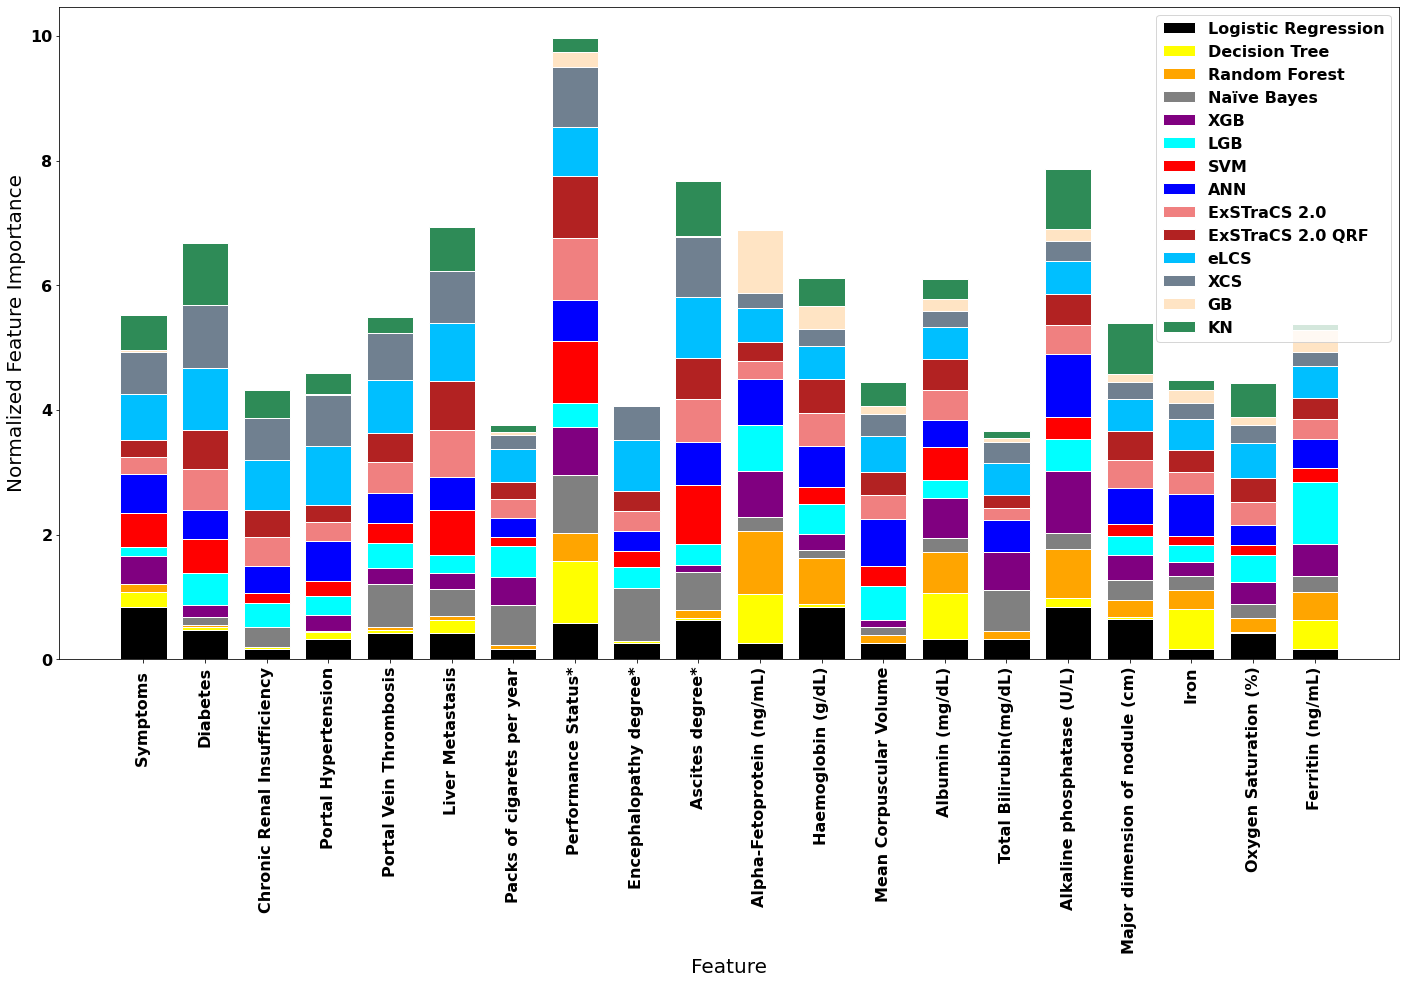

In [86]:
compound_FI_plot(top_fi_ave_norm_list,algorithmsToRun,algColors,all_feature_listToViz,'Norm')

##  Fraction Adjustment of Normalized Feature importances
- Each scores from each algorithm divided by sum of all scores

In [87]:
fracLists = []

for each in top_fi_ave_norm_list:
    fracList = []
    for i in range(len(each)):
        fracList.append((each[i]/(sum(each))))
    fracLists.append(fracList)

## Compound Feature Importance Plot (Normalized + Fraction Adjustment)

Plotting with 14 algorithms.


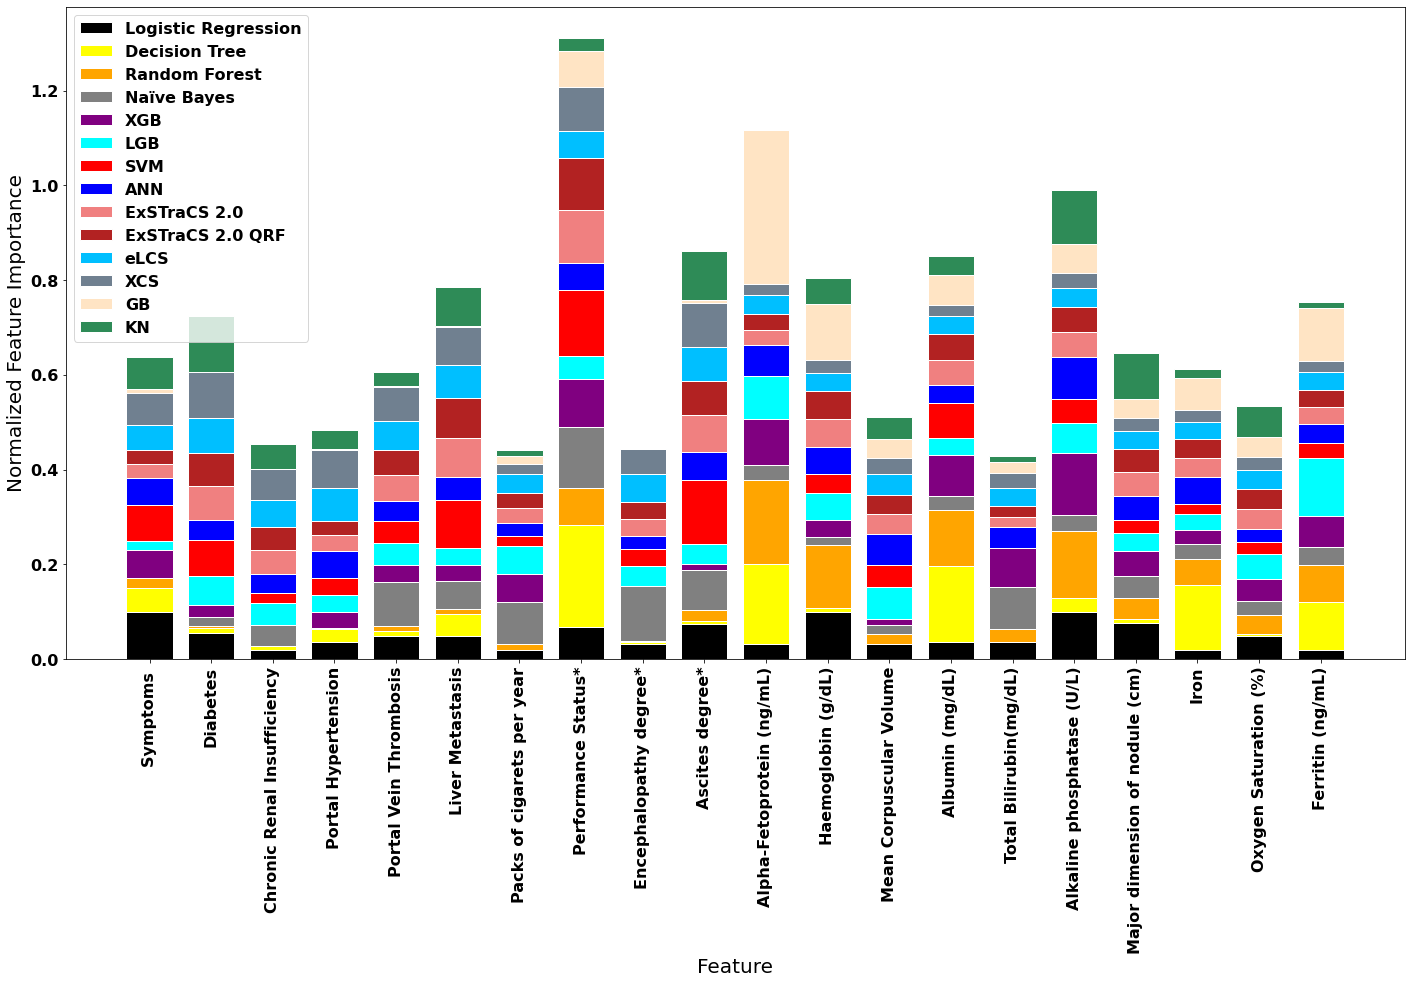

In [88]:
compound_FI_plot(fracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac')

##  Performance Weighting of Normalized Feature importances

In [89]:
#Prepare weights
weights = []

# replace all balanced accuraces <=.5 with 0
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] <= .5:
        ave_metric_list[i] = 0

# normalize balanced accuracies
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] == 0:
        weights.append(0)
    else:
        weights.append((ave_metric_list[i]-0.5)/0.5)
        
        
# Weight normalized feature importances
weightedLists = []

for i in range(len(top_fi_ave_norm_list)):
    weightList = np.multiply(weights[i],top_fi_ave_norm_list[i]).tolist()
    weightedLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Perf. Weight Adjustment)

Plotting with 14 algorithms.


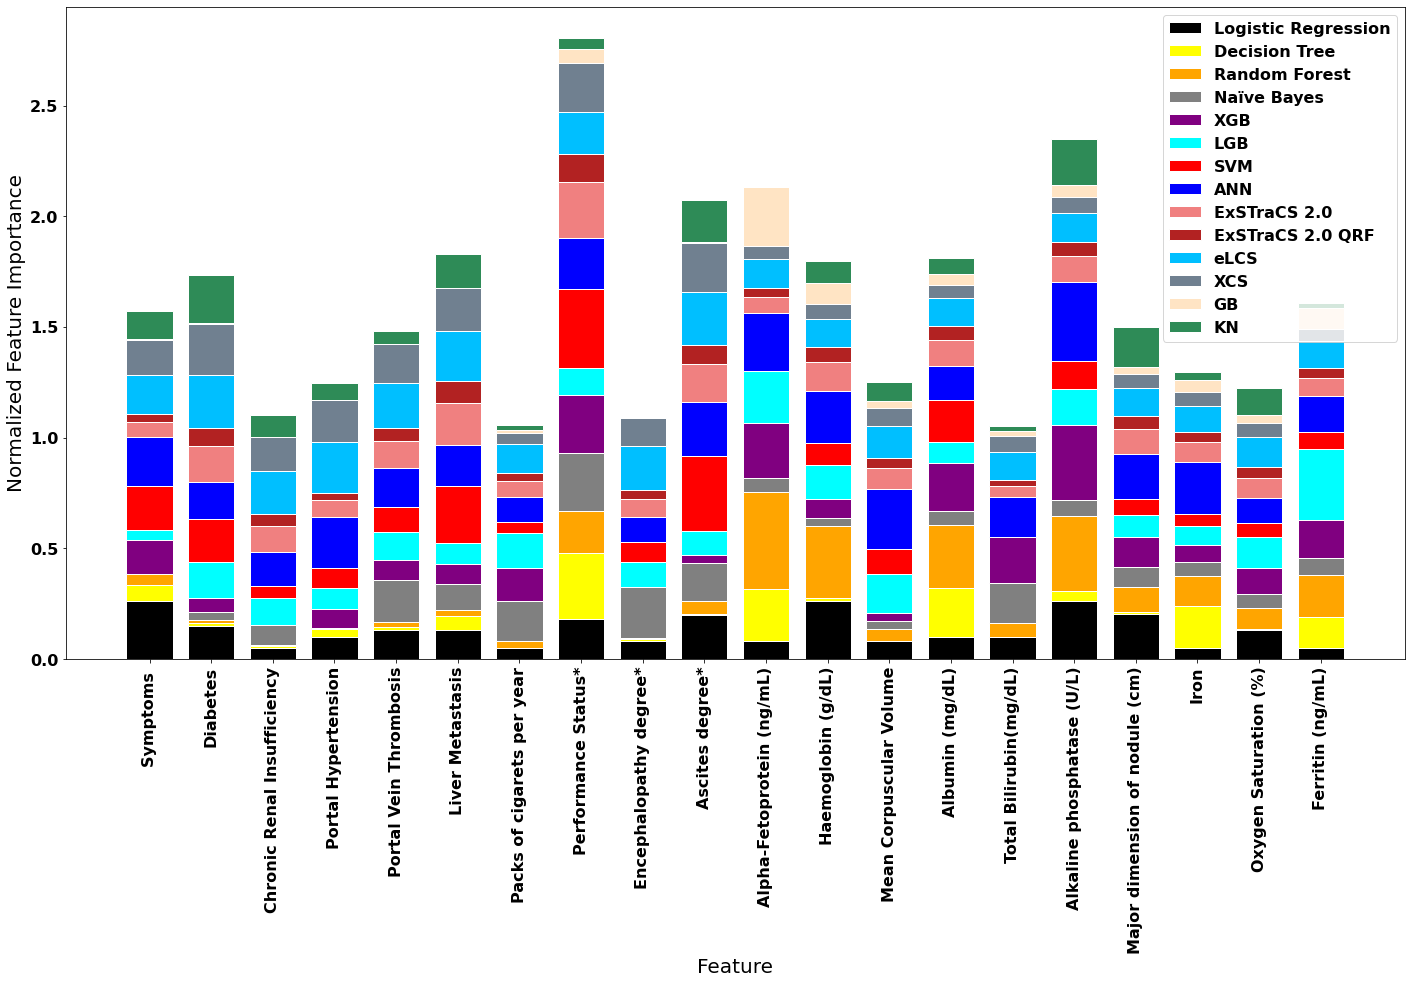

In [90]:
compound_FI_plot(weightedLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Weight')

##  Performance Weighting of Fract. Adj. and Normalized Feature importances

In [91]:
# Weight normalized feature importances
weightedFracLists = []

for i in range(len(fracLists)):
    weightList = np.multiply(weights[i],fracLists[i]).tolist()
    weightedFracLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Frac. + Perf. Weight Adjustment)

Plotting with 14 algorithms.


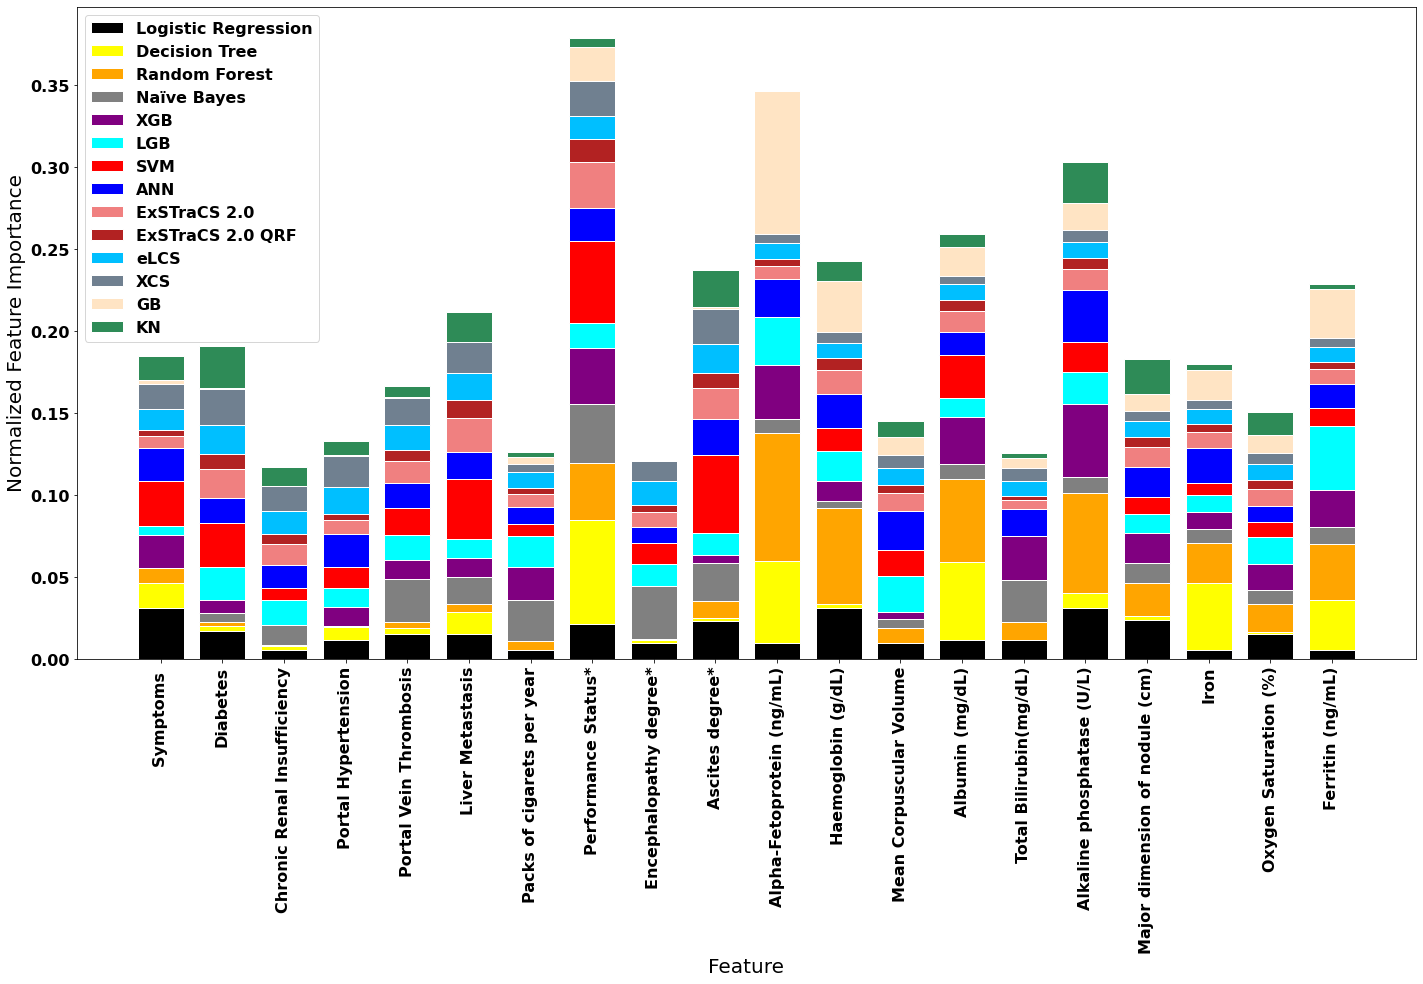

In [92]:
compound_FI_plot(weightedFracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac_Weight')

# Runtime Report